<a href="https://colab.research.google.com/github/l8518/geot-faas/blob/main/data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencies

In [1]:
import datetime

import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import Series

import seaborn as sns
sns.set()

#   Data Analysis

In [2]:
dataset = pd.read_parquet('dataset.parquet')

In [3]:
dataset.columns

Index(['driver_invocation', 'workload_invocation', 'dirty_measurement',
       'folder_uuid', '1_run_id', '2_thread_id', 'SAAFMemoryDeltaError',
       'SAAFMemoryError', 'contextSwitches', 'contextSwitchesDelta', 'cpuIdle',
       'cpuIdleDelta', 'cpuIowait', 'cpuIowaitDelta', 'cpuIrq', 'cpuIrqDelta',
       'cpuKrn', 'cpuKrnDelta', 'cpuModel', 'cpuNice', 'cpuNiceDelta',
       'cpuSoftIrq', 'cpuSoftIrqDelta', 'cpuType', 'cpuUsr', 'cpuUsrDelta',
       'endTime', 'frameworkRuntime', 'frameworkRuntimeDeltas', 'freeMemory',
       'functionName', 'lang', 'latency', 'linuxVersion', 'message',
       'newcontainer', 'payload', 'platform', 'roundTripTime', 'runtime',
       'runtimeOverlap', 'startTime', 'totalMemory', 'userRuntime', 'uuid',
       'vendorId', 'version', 'vmcpusteal', 'vmcpustealDelta', 'vmuptime',
       'containerID', 'functionRegion', 'pageFaults', 'pageFaultsDelta',
       'functionMemory', 'vmID', '__index_level_0__', 'tod_utc',
       'measure_group', 'timezone', 'lo

In [4]:
# dataset.groupby( ['driver_invocation', 'provider'])['workload_invocation'].nunique()
# dataset.groupby(['local_tod'])['runtime'].agg(['count'])

coefficient_of_variation = lambda x: np.std(x, ddof=1) / np.mean(x) 

## Measurement Errors (TODO)

In [5]:
measure_target = {'AWS': 10 , 'AZURE': 9 , 'GCP': 10}

In [6]:
measurement_df = dataset.groupby(['driver_invocation', 'provider'])['workload_invocation'].nunique().unstack('provider')

<AxesSubplot:>

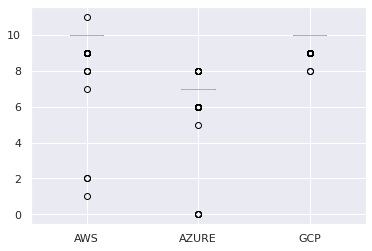

In [7]:
measurement_df.boxplot()

In [8]:
measurement_df[measurement_df['AWS'] > 10]

provider                 AWS  AZURE  GCP
driver_invocation                       
2021-08-04 20:30:04.065   11      7   10

In [9]:
dataset['driver_invocation']

0          2021-08-02 00:00:04.969
1          2021-08-07 22:30:03.072
2          2021-08-02 00:00:04.969
3          2021-08-07 22:30:03.072
4          2021-08-02 00:00:04.969
                     ...          
49476535   2021-10-04 04:00:03.936
49476536   2021-10-04 04:00:03.936
49476537   2021-10-04 04:00:03.936
49476538   2021-10-04 04:00:03.936
49476539   2021-10-04 04:00:03.936
Name: driver_invocation, Length: 49476540, dtype: datetime64[ns]

## Provider Differences

### Runtime

In [10]:
cov_provider_df = dataset.groupby( ['provider'])['runtime'].apply(coefficient_of_variation).dropna().reset_index(name='Runtime CV').set_index(['provider'])
mean_provider_df = dataset.groupby( ['provider'])['runtime'].mean().dropna().reset_index(name='Runtime Mean').set_index(['provider'])

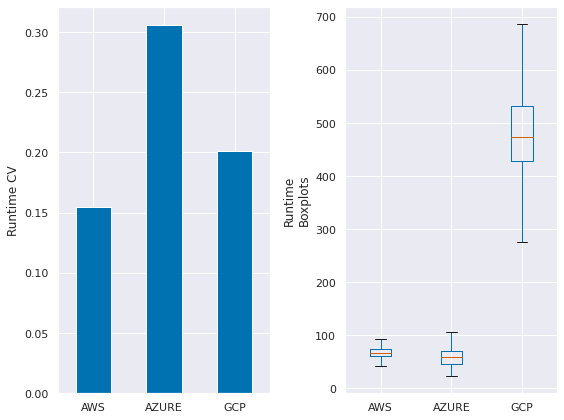

             runtime                                                     \
               count        mean        std    min    25%    50%    75%   
provider                                                                  
AWS       18442076.0   68.977945  10.680119   31.0   62.0   67.0   75.0   
AZURE     12548544.0   59.712476  18.257945   24.0   46.0   60.0   70.0   
GCP       18485920.0  476.420318  95.894786  105.0  429.0  474.0  532.0   

                   
              max  
provider           
AWS        1855.0  
AZURE     13352.0  
GCP        8112.0  


In [11]:
matplotlib.style.use('seaborn-colorblind')
# Plot Coefficient Of Variation Per Cloud Provider:
fig, axes = plt.subplots(figsize=(8,6), ncols=2, nrows=1, frameon=False, sharex=True)

# mean_provider_df.plot(kind='bar', ax=axes[0])
# axes[0].set_xlabel('')
# axes[0].title.set_text('Runtime Mean')
# axes[0].get_legend().remove()

cov_provider_df.plot(kind='bar', ax=axes[0])
#axes[0].title.set_text('Runtime CV')
axes[0].set_xlabel('')
axes[0].set_ylabel('Runtime CV')
axes[0].get_legend().remove()

gs = axes[1].get_gridspec()
axes[1].remove()
# axes[2].remove()
# axes[3].remove()
axbig = fig.add_subplot(gs[1:])

dataset[['provider', 'runtime']].sort_values(by=['provider']).groupby(['provider'], observed=True).boxplot(subplots=False, ax=axbig, showfliers=False)

labels = []
for tick in axbig.get_xticklabels():
  provider = tick.get_text()[1:].split(',')[0]
  labels.append(f"{provider}")
axbig.set_xticklabels(labels)
axbig.set_ylabel('Runtime\nBoxplots')

# Fix Label Rotation
plt.setp(axbig.get_xticklabels(), rotation=0)
plt.setp(axes[0].get_xticklabels(), rotation=0)

fig.tight_layout()

plt.savefig('provider_mean_cov.pdf')
plt.show()
plt.close()
print(dataset[['provider', 'runtime']].groupby(['provider'], observed=True).describe())

### Container Ids

In [12]:
uuid_unique_count_df = dataset.groupby(['measure_group', 'provider', 'region', 'driver_invocation'], observed=True)['uuid'].nunique().reset_index(name='Unique Container Id')

         Unique Container Id                                               \
                       count       mean        std  min   25%   50%   75%   
provider                                                                    
AWS                  30738.0   3.997885   0.094564  3.0   4.0   4.0   4.0   
AZURE                21489.0   3.269673   0.584623  1.0   3.0   3.0   4.0   
GCP                  30816.0  15.088363  14.749452  4.0  10.0  11.0  13.0   

                 
            max  
provider         
AWS         8.0  
AZURE       5.0  
GCP       163.0  


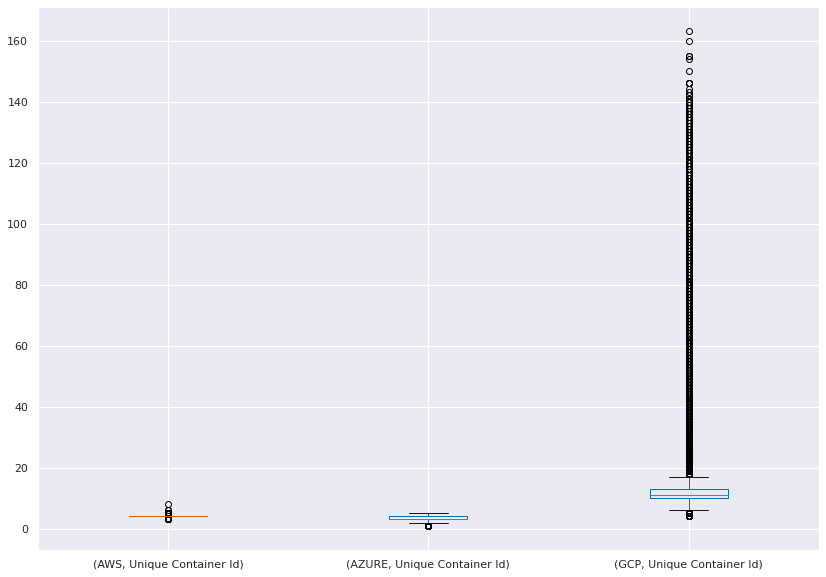

In [13]:
uuid_unique_count_df[['provider', 'Unique Container Id']].groupby(['provider'], observed=True).boxplot(figsize=(14,10), subplots=False)
print(uuid_unique_count_df[['provider', 'Unique Container Id']].groupby(['provider'], observed=True).describe())

### CPUs

In [14]:
dataset[['provider', 'cpuModel', 'cpuType']].drop_duplicates()

provider  cpuModel                                            cpuType
0             AWS      63.0    Intel(R) Xeon(R) Processor @ 2.50GHz - Model 63
6006          AWS      63.0    Intel(R) Xeon(R) Processor @ 3.00GHz - Model 63
18442076    AZURE      79.0  Intel(R) Xeon(R) CPU E5-2673 v4 @ 2.30GHz - Mo...
18442077    AZURE      63.0  Intel(R) Xeon(R) CPU E5-2673 v3 @ 2.40GHz - Mo...
18442103    AZURE      85.0  Intel(R) Xeon(R) Platinum 8171M CPU @ 2.60GHz ...
18969741    AZURE      85.0  Intel(R) Xeon(R) Platinum 8272CL CPU @ 2.60GHz...
30990620      GCP      85.0                                 unknown - Model 85
30990649      GCP      79.0                                 unknown - Model 79
30991205      GCP      63.0                                 unknown - Model 63

In [15]:
provider_cpus_df = dataset.groupby(['provider'], observed=True)['cpuType'].nunique()
provider_cpus_df.groupby(['provider']).describe()

count  mean  std  min  25%  50%  75%  max
provider                                           
AWS         1.0   2.0  NaN  2.0  2.0  2.0  2.0  2.0
AZURE       1.0   4.0  NaN  4.0  4.0  4.0  4.0  4.0
GCP         1.0   3.0  NaN  3.0  3.0  3.0  3.0  3.0

In [16]:
cpu_count_df = dataset.groupby(['measure_group', 'provider', 'region', 'driver_invocation'], observed=True)['cpuType'].nunique().reset_index(name='Unique CPU Types')

Average CPU Types used per Invocation
         Unique CPU Types                                             
                    count      mean       std  min  25%  50%  75%  max
provider                                                              
AWS               30738.0  1.048604  0.215043  1.0  1.0  1.0  1.0  2.0
AZURE             21489.0  1.759458  0.659487  1.0  1.0  2.0  2.0  4.0
GCP               30816.0  1.572333  0.619306  1.0  1.0  2.0  2.0  3.0


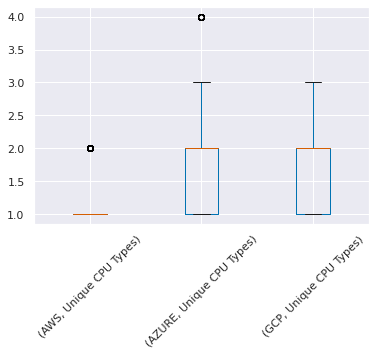

In [17]:
print('Average CPU Types used per Invocation')
cpu_count_df.groupby(['provider']).boxplot(subplots=False, rot=45)
print(cpu_count_df.groupby(['provider']).describe())

Double Schedule + Missing Measurements

## Regional Provider Differences

In [18]:
# Common Stuff
provider_region_mapping = {}
provider_region_mg_df = dataset.groupby( ['provider', 'region'], observed=True)['measure_group'].unique().reset_index()
provider_region_mg_df
for index, row in provider_region_mg_df.iterrows():
  for measure_group in row['measure_group']:
    region = row['region']
    provider = row['provider']
    measure_group = row['measure_group'][0]
    provider_region_mapping[f"({provider}, {region})"] = {'region': region, 'measure_group': measure_group, 'provider': provider}
    provider_region_mapping[f"({provider}, {region}, {measure_group})"] = {'region': region, 'measure_group': measure_group, 'provider': provider}

### Runtime Mean and CV

In [19]:
measure_group_df = dataset.groupby(['provider', 'region'], observed=True)['measure_group'].unique().dropna().reset_index()

In [20]:
cov_provider_region_df = dataset.groupby( ['measure_group', 'provider', 'region'], observed=True)['runtime'].apply(coefficient_of_variation).reset_index(name='Runtime CV').set_index(['provider', 'region'])
# mean_provider_region_df = dataset.groupby( ['measure_group', 'provider', 'region'], observed=True)['runtime'].mean().reset_index(name='Runtime Mean').set_index(['provider', 'region'])

AWS


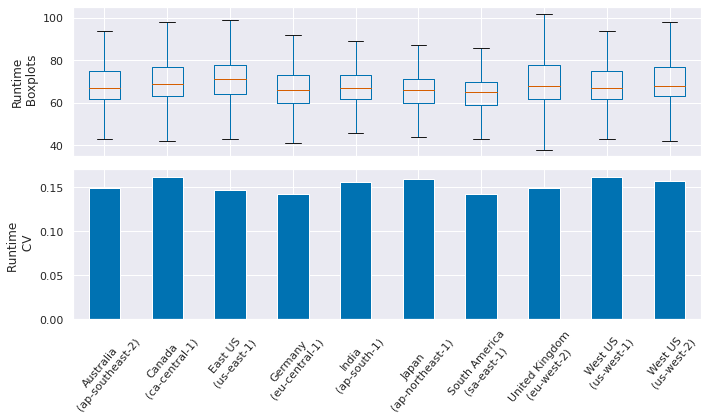

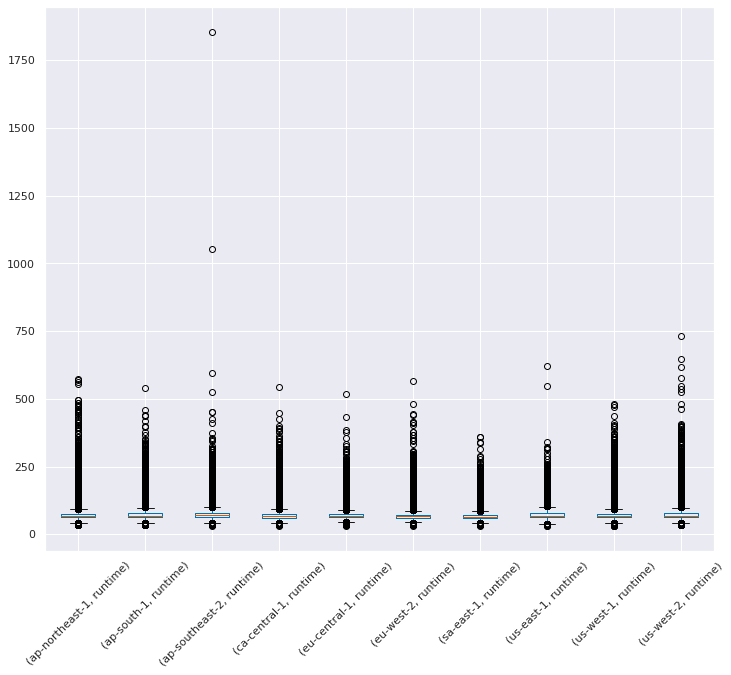

AZURE


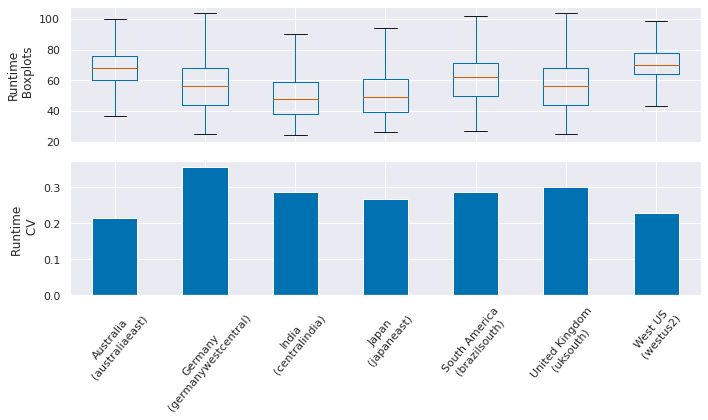

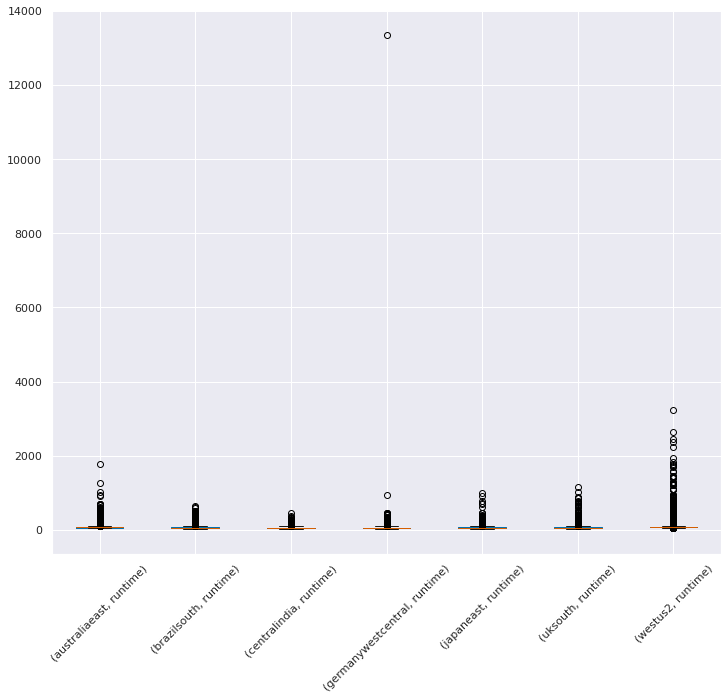

GCP


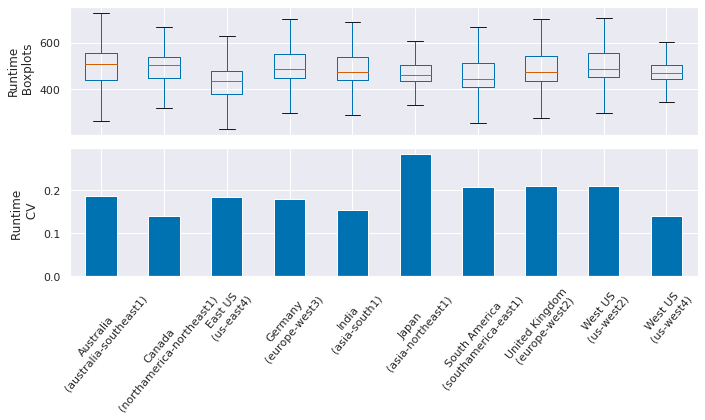

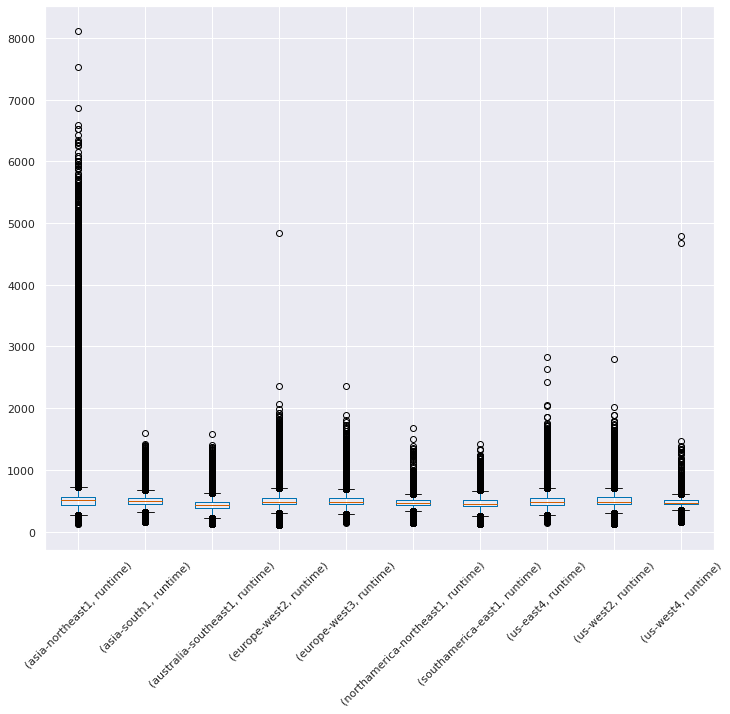

In [21]:
# mean_provider_region_df.sort_values(by=['measure_group', 'provider', 'region'])
cov_provider_region_df.sort_values(by=['measure_group', 'provider', 'region'])

for provider in cov_provider_region_df.index.get_level_values('provider').unique():
  fig, axes = plt.subplots(figsize=(10,6), nrows=2, frameon=False)

  #mean_provider_region_df[cov_provider_region_df.index.isin([provider], level='provider')].plot(kind='bar', ax=axes[0])
  dataset[['provider', 'region', 'runtime']][dataset['provider'] == provider].groupby(['region'], observed=True).boxplot(subplots=False, ax=axes[0], showfliers=False)

  cov_provider_region_df[cov_provider_region_df.index.isin([provider], level='provider')].plot(kind='bar', ax=axes[1])

  axes[0].set_ylabel('Runtime\n Boxplots')
  # axes[0].get_legend().remove()
  labels = []
  for tick in axes[0].get_xticklabels():
    labels.append('')
  axes[0].set_xticklabels(labels)

  for tick in axes[1].get_xticklabels():
    tick.set_rotation(50)
  
  # Set Region Names
  labels = []
  for tick in axes[1].get_xticklabels():
    mapping = provider_region_mapping[tick.get_text()]
    region = mapping['region']
    measure_group = mapping['measure_group']
    labels.append(f"{measure_group}\n({region})")
  
  axes[1].get_legend().remove()
  axes[1].set_ylabel('Runtime \n CV')
  axes[1].set_xticklabels(labels)
  axes[1].set_xlabel('')


  fig.tight_layout()

  print(provider)
  plt.savefig(f'provider_region_mean_cov_{provider}.pdf')
  plt.show()
  plt.close()

  # Generate a control figure - because I cannot fore the matching
  fig, axes = plt.subplots(figsize=(12,10))
  dataset[['provider', 'region', 'runtime']][dataset['provider'] == provider].groupby(['region'], observed=True).boxplot(subplots=False, ax=axes, rot=45)
  plt.savefig(f'provider_region_mean_cov_{provider}_box.pdf')
  plt.show()
  plt.close()

### Container Ids

In [22]:
uuid_unique_count_df = dataset.groupby(['measure_group', 'provider', 'region', 'driver_invocation'], observed=True)['uuid'].nunique().reset_index(name='Unique Container Id')

In [23]:
uuid_unique_count_grouped = dataset.groupby(['measure_group', 'provider', 'region', 'driver_invocation'], observed=True)['uuid'].nunique().reset_index(name='Unique Container Id')

In [24]:
uuid_mean_unique_count_df = uuid_unique_count_df.groupby(['measure_group', 'provider', 'region'], observed=True)['Unique Container Id'].mean().reset_index(name='Mean Unique Container Id').set_index(['provider', 'region'])
uuid_cv_unique_count_df = uuid_unique_count_df.groupby(['measure_group', 'provider', 'region'], observed=True)['Unique Container Id'].apply(coefficient_of_variation).reset_index(name='CV Unique Container Id').set_index(['provider', 'region'])

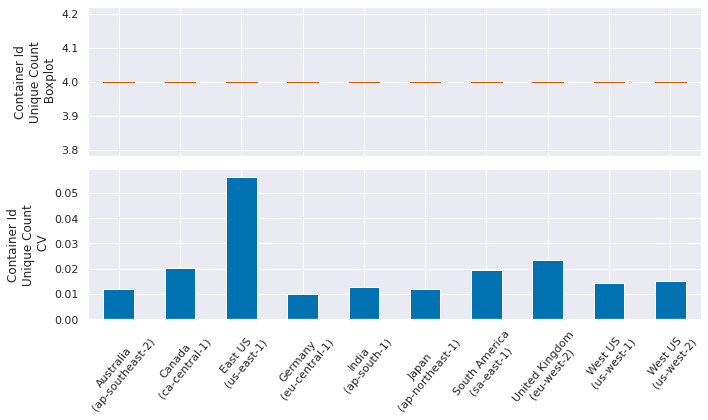

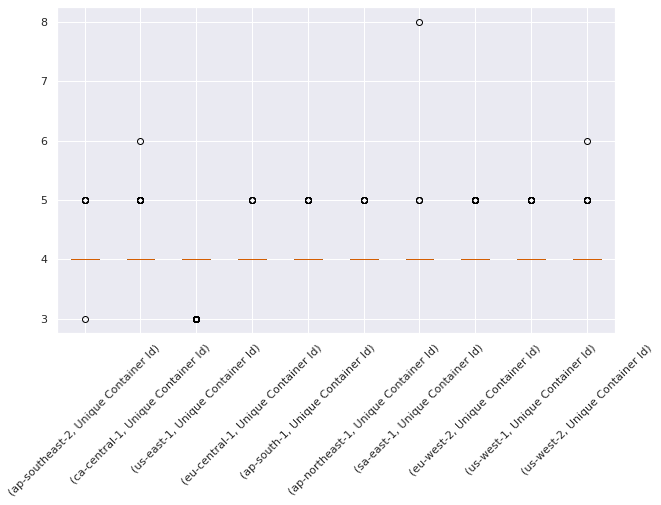

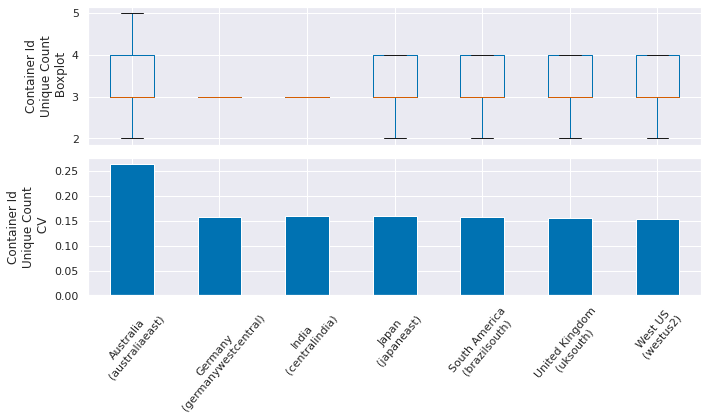

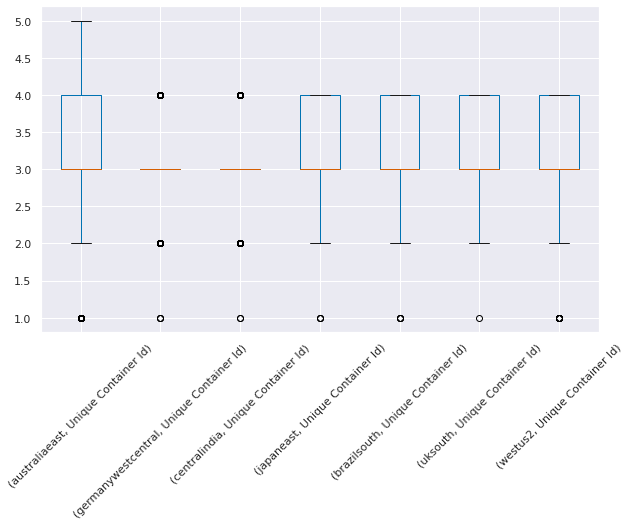

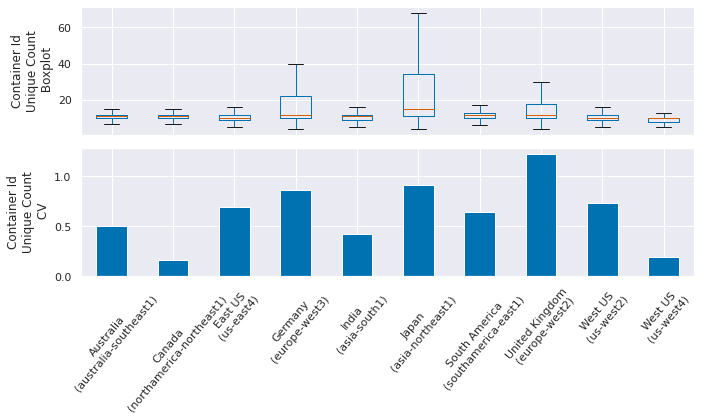

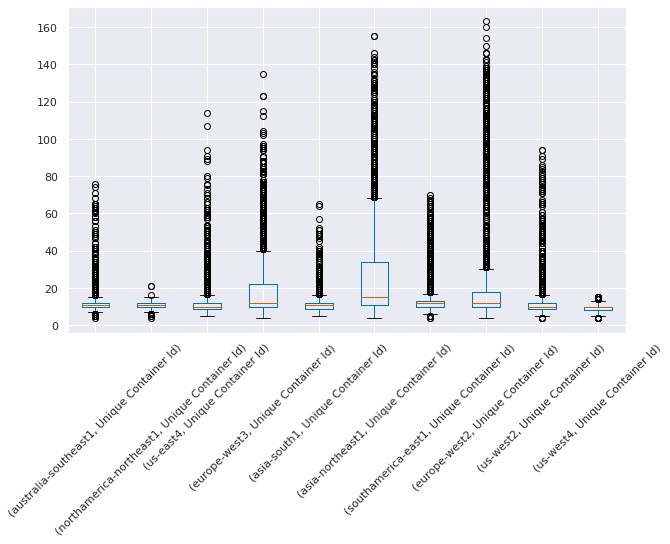

In [25]:
uuid_mean_unique_count_df.sort_values(by=['measure_group', 'provider', 'region'])
uuid_cv_unique_count_df.sort_values(by=['measure_group', 'provider', 'region'])

for provider in uuid_cv_unique_count_df.index.get_level_values('provider').unique():
  fig, axes = plt.subplots(figsize=(10,6), nrows=2, frameon=False)

  # fig.add_subplot(axsub)
  uuid_unique_count_grouped[uuid_unique_count_grouped['provider'] == provider].groupby(['region'], observed=True).boxplot(subplots=False, ax=axes[0], showfliers=False)
  uuid_cv_unique_count_df[uuid_cv_unique_count_df.index.isin([provider], level='provider')].plot(kind='bar', ax=axes[1])

  axes[0].set_ylabel('Container Id\nUnique Count\n Boxplot')
  labels = []
  for tick in axes[0].get_xticklabels():
    labels.append('')
  axes[0].set_xticklabels(labels)

  # axes[0].get_legend().remove()

  for tick in axes[1].get_xticklabels():
    tick.set_rotation(50)
  
  # Set Region Names
  labels = []
  for tick in axes[1].get_xticklabels():
    mapping = provider_region_mapping[tick.get_text()]
    region = mapping['region']
    measure_group = mapping['measure_group']
    labels.append(f"{measure_group}\n({region})")
  
  axes[1].get_legend().remove()
  axes[1].set_ylabel('Container Id\nUnique Count\n CV')
  axes[1].set_xticklabels(labels)
  axes[1].set_xlabel('')


  fig.tight_layout()

  plt.savefig(f'provider_region_container_ids_{provider}.pdf')
  plt.show()
  plt.close()

  # Generate a control figure - because I cannot fore the matching
  fig, axes = plt.subplots(figsize=(10,6))
  uuid_unique_count_grouped[uuid_unique_count_grouped['provider'] == provider].groupby(['region'], observed=True).boxplot(subplots=False, ax=axes, rot=45)
  plt.savefig(f'provider_region_container_ids_{provider}_box.pdf')
  plt.show()
  plt.close()

### CPU types

In [26]:
unique_cpu_types_df = dataset.groupby(['measure_group', 'provider', 'region'], observed=True)['cpuType'].unique()
unique_cpu_types_df.to_csv('unique_cpu_types_region_provider', index=False)
unique_cpu_types_df

measure_group   provider  region                 
Australia       AWS       ap-southeast-2             [Intel(R) Xeon(R) Processor @ 2.50GHz - Model ...
                AZURE     australiaeast              [Intel(R) Xeon(R) CPU E5-2673 v4 @ 2.30GHz - M...
                GCP       australia-southeast1                [unknown - Model 79, unknown - Model 85]
Canada          AWS       ca-central-1               [Intel(R) Xeon(R) Processor @ 2.50GHz - Model ...
                GCP       northamerica-northeast1                                 [unknown - Model 85]
East US         AWS       us-east-1                  [Intel(R) Xeon(R) Processor @ 2.50GHz - Model ...
                GCP       us-east4                            [unknown - Model 79, unknown - Model 85]
Germany         AWS       eu-central-1               [Intel(R) Xeon(R) Processor @ 2.50GHz - Model ...
                AZURE     germanywestcentral         [Intel(R) Xeon(R) Platinum 8272CL CPU @ 2.60GH...
                GCP    

In [27]:
unique_cpu_types_count_df = dataset.groupby(['measure_group', 'provider', 'region'], observed=True)['cpuType'].nunique()
unique_cpu_types_count_df

measure_group   provider  region                 
Australia       AWS       ap-southeast-2             2
                AZURE     australiaeast              4
                GCP       australia-southeast1       2
Canada          AWS       ca-central-1               2
                GCP       northamerica-northeast1    1
East US         AWS       us-east-1                  2
                GCP       us-east4                   2
Germany         AWS       eu-central-1               2
                AZURE     germanywestcentral         3
                GCP       europe-west3               2
India           AWS       ap-south-1                 2
                AZURE     centralindia               3
                GCP       asia-south1                1
Japan           AWS       ap-northeast-1             2
                AZURE     japaneast                  4
                GCP       asia-northeast1            3
South America   AWS       sa-east-1                  2
               

In [28]:
unique_cpu_types_count_per_invocation_df = dataset.groupby(['measure_group', 'provider', 'region', 'driver_invocation'], observed=True)['cpuType'].nunique().reset_index()
unique_cpu_types_count_per_invocation_df.groupby(['provider', 'region']).describe()

cpuType                                     \
                                   count      mean       std  min  25%  50%   
provider region                                                               
AWS      ap-northeast-1           3076.0  1.013979  0.117423  1.0  1.0  1.0   
         ap-south-1               3074.0  1.044893  0.207102  1.0  1.0  1.0   
         ap-southeast-2           3077.0  1.032499  0.177351  1.0  1.0  1.0   
         ca-central-1             3078.0  1.070500  0.256030  1.0  1.0  1.0   
         eu-central-1             3076.0  1.011378  0.106078  1.0  1.0  1.0   
         eu-west-2                3074.0  1.002602  0.050956  1.0  1.0  1.0   
         sa-east-1                3074.0  1.021796  0.146040  1.0  1.0  1.0   
         us-east-1                3068.0  1.198175  0.398689  1.0  1.0  1.0   
         us-west-1                3074.0  1.088809  0.284515  1.0  1.0  1.0   
         us-west-2                3067.0  1.001630  0.040350  1.0  1.0  1.0   
AZURE    australiaeast            3050.0  1.888852  0.664254  1.0  1.0  2.0   
         brazilsouth              3061.0  2.048677  0.635483  1.0  2.0  2.0   
         centralindia             3076.0  1.436281  0.500572  1.0  1.0  1.0   
         germanywestcentral       3078.0  1.635802  0.523958  1.0  1.0  2.0   
         japaneast                3074.0  1.986337  0.617414  1.0  2.0  2.0   
         uksouth                  3074.0  2.044242  0.667692  1.0  2.0  2.0   
         westus2                  3076.0  1.278934  0.514718  1.0  1.0  1.0   
GCP      asia-northeast1          3081.0  2.674781  0.507774  1.0  2.0  3.0   
         asia-south1              3082.0  1.000000  0.000000  1.0  1.0  1.0   
         australia-southeast1     3082.0  1.970149  0.170203  1.0  2.0  2.0   
         europe-west2             3082.0  1.265412  0.441624  1.0  1.0  1.0   
         europe-west3             3082.0  1.926022  0.261777  1.0  2.0  2.0   
         northamerica-northeast1  3082.0  1.000000  0.000000  1.0  1.0  1.0   
         southamerica-east1       3081.0  1.987017  0.113218  1.0  2.0  2.0   
         us-east4                 3082.0  1.900065  0.299962  1.0  2.0  2.0   
         us-west2                 3081.0  1.000000  0.000000  1.0  1.0  1.0   
         us-west4                 3081.0  1.000000  0.000000  1.0  1.0  1.0   

                                            
                                  75%  max  
provider region                             
AWS      ap-northeast-1           1.0  2.0  
         ap-south-1               1.0  2.0  
         ap-southeast-2           1.0  2.0  
         ca-central-1             1.0  2.0  
         eu-central-1             1.0  2.0  
         eu-west-2                1.0  2.0  
         sa-east-1                1.0  2.0  
         us-east-1                1.0  2.0  
         us-west-1                1.0  2.0  
         us-west-2                1.0  2.0  
AZURE    australiaeast            2.0  4.0  
         brazilsouth              2.0  4.0  
         centralindia             2.0  3.0  
         germanywestcentral       2.0  3.0  
         japaneast                2.0  4.0  
         uksouth                  2.0  4.0  
         westus2                  1.0  3.0  
GCP      asia-northeast1          3.0  3.0  
         asia-south1              1.0  1.0  
         australia-southeast1     2.0  2.0  
         europe-west2             2.0  2.0  
         europe-west3             2.0  2.0  
         northamerica-northeast1  1.0  1.0  
         southamerica-east1       2.0  2.0  
         us-east4                 2.0  2.0  
         us-west2                 1.0  1.0  
         us-west4                 1.0  1.0

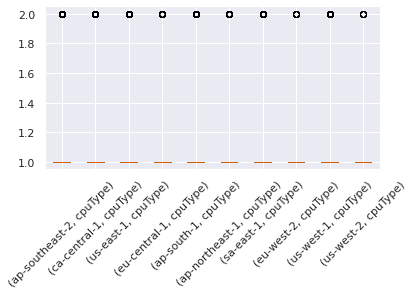

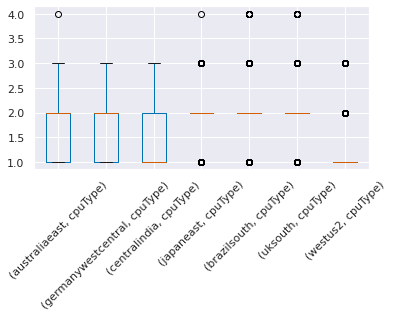

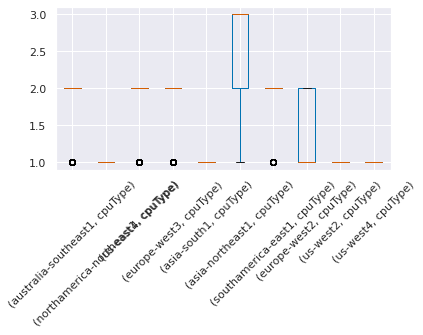

In [29]:
# Boxplots over CPUs per Invocation
for provider in unique_cpu_types_count_per_invocation_df['provider'].unique():
  fig, axes = plt.subplots(figsize=(6,3), nrows=1, ncols=1, frameon=False)
  unique_cpu_types_count_per_invocation_df[unique_cpu_types_count_per_invocation_df['provider'] == provider].groupby('region', observed=True).boxplot(subplots=False, rot=45, ax=axes)
  plt.savefig(f'unique_cpu_types_count_per_invocation_{provider}_box.pdf')
  plt.show()
  plt.close()

### Correlation Stuff - is that even possible?!

In [30]:
regional_provider_differences = dataset[ ['provider', 'region', 'runtime', 'driver_invocation'] ]
regional_provider_differences_avg_runtime = regional_provider_differences.groupby(['provider', 'region', 'driver_invocation'],observed=True).mean().reset_index()

In [31]:
regional_provider_differences_avg_runtime

provider          region       driver_invocation     runtime
0          AWS  ap-northeast-1 2021-07-31 22:47:12.294   68.658333
1          AWS  ap-northeast-1 2021-07-31 23:00:03.691   63.256667
2          AWS  ap-northeast-1 2021-07-31 23:30:04.339   66.755000
3          AWS  ap-northeast-1 2021-08-01 00:00:04.087   69.508333
4          AWS  ap-northeast-1 2021-08-01 00:30:03.747   71.690000
...        ...             ...                     ...         ...
83038      GCP        us-west4 2021-10-04 02:00:03.836  478.756667
83039      GCP        us-west4 2021-10-04 02:30:03.417  457.953333
83040      GCP        us-west4 2021-10-04 03:00:04.572  449.930000
83041      GCP        us-west4 2021-10-04 03:30:03.480  450.338333
83042      GCP        us-west4 2021-10-04 04:00:03.936  471.013333

[83043 rows x 4 columns]

In [32]:
region_dummies = pd.get_dummies(regional_provider_differences_avg_runtime, prefix=['region'], columns=['region'])

In [33]:
region_dummies

provider       driver_invocation     runtime  region_ap-northeast-1  \
0          AWS 2021-07-31 22:47:12.294   68.658333                      1   
1          AWS 2021-07-31 23:00:03.691   63.256667                      1   
2          AWS 2021-07-31 23:30:04.339   66.755000                      1   
3          AWS 2021-08-01 00:00:04.087   69.508333                      1   
4          AWS 2021-08-01 00:30:03.747   71.690000                      1   
...        ...                     ...         ...                    ...   
83038      GCP 2021-10-04 02:00:03.836  478.756667                      0   
83039      GCP 2021-10-04 02:30:03.417  457.953333                      0   
83040      GCP 2021-10-04 03:00:04.572  449.930000                      0   
83041      GCP 2021-10-04 03:30:03.480  450.338333                      0   
83042      GCP 2021-10-04 04:00:03.936  471.013333                      0   

       region_ap-south-1  region_ap-southeast-2  region_ca-central-1  \
0                      0                      0                    0   
1                      0                      0                    0   
2                      0                      0                    0   
3                      0                      0                    0   
4                      0                      0                    0   
...                  ...                    ...                  ...   
83038                  0                      0                    0   
83039                  0                      0                    0   
83040                  0                      0                    0   
83041                  0                      0                    0   
83042                  0                      0                    0   

       region_eu-central-1  region_eu-west-2  region_sa-east-1  ...  \
0                        0                 0                 0  ...   
1                        0                 0                 0  ...   
2                        0                 0                 0  ...   
3                        0                 0                 0  ...   
4                        0                 0                 0  ...   
...                    ...               ...               ...  ...   
83038                    0                 0                 0  ...   
83039                    0                 0                 0  ...   
83040                    0                 0                 0  ...   
83041                    0                 0                 0  ...   
83042                    0                 0                 0  ...   

       region_asia-northeast1  region_asia-south1  \
0                           0                   0   
1                           0                   0   
2                           0                   0   
3                           0                   0   
4                           0                   0   
...                       ...                 ...   
83038                       0                   0   
83039                       0                   0   
83040                       0                   0   
83041                       0                   0   
83042                       0                   0   

       region_australia-southeast1  region_europe-west2  region_europe-west3  \
0                                0                    0                    0   
1                                0                    0                    0   
2                                0                    0                    0   
3                                0                    0                    0   
4                                0                    0                    0   
...                            ...                  ...                  ...   
83038                            0                    0                    0   
83039                            0                    0                    0   
83040 

In [34]:
df = pd.concat( [regional_provider_differences_avg_runtime, region_dummies] , axis=1)
df

provider          region       driver_invocation     runtime provider  \
0          AWS  ap-northeast-1 2021-07-31 22:47:12.294   68.658333      AWS   
1          AWS  ap-northeast-1 2021-07-31 23:00:03.691   63.256667      AWS   
2          AWS  ap-northeast-1 2021-07-31 23:30:04.339   66.755000      AWS   
3          AWS  ap-northeast-1 2021-08-01 00:00:04.087   69.508333      AWS   
4          AWS  ap-northeast-1 2021-08-01 00:30:03.747   71.690000      AWS   
...        ...             ...                     ...         ...      ...   
83038      GCP        us-west4 2021-10-04 02:00:03.836  478.756667      GCP   
83039      GCP        us-west4 2021-10-04 02:30:03.417  457.953333      GCP   
83040      GCP        us-west4 2021-10-04 03:00:04.572  449.930000      GCP   
83041      GCP        us-west4 2021-10-04 03:30:03.480  450.338333      GCP   
83042      GCP        us-west4 2021-10-04 04:00:03.936  471.013333      GCP   

            driver_invocation     runtime  region_ap-northeast-1  \
0     2021-07-31 22:47:12.294   68.658333                      1   
1     2021-07-31 23:00:03.691   63.256667                      1   
2     2021-07-31 23:30:04.339   66.755000                      1   
3     2021-08-01 00:00:04.087   69.508333                      1   
4     2021-08-01 00:30:03.747   71.690000                      1   
...                       ...         ...                    ...   
83038 2021-10-04 02:00:03.836  478.756667                      0   
83039 2021-10-04 02:30:03.417  457.953333                      0   
83040 2021-10-04 03:00:04.572  449.930000                      0   
83041 2021-10-04 03:30:03.480  450.338333                      0   
83042 2021-10-04 04:00:03.936  471.013333                      0   

       region_ap-south-1  region_ap-southeast-2  ...  region_asia-northeast1  \
0                      0                      0  ...                       0   
1                      0                      0  ...                       0   
2                      0                      0  ...                       0   
3                      0                      0  ...                       0   
4                      0                      0  ...                       0   
...                  ...                    ...  ...                     ...   
83038                  0                      0  ...                       0   
83039                  0                      0  ...                       0   
83040                  0                      0  ...                       0   
83041                  0                      0  ...                       0   
83042                  0                      0  ...                       0   

       region_asia-south1  region_australia-southeast1  region_europe-west2  \
0                       0                            0                    0   
1                       0                            0                    0   
2                       0                            0                    0   
3                       0                            0                    0   
4                       0                            0                    0   
...                   ...                          ...                  ...   
83038                   0                            0                    0   
83039                   0                            0                    0   
83040                   0                            0                    0   
83041                   0                            0                    0   
83042                   0                            0                    0   

       region_europe-west3  region_northamerica-northeast1  \
0                        0                               0   
1                        0                               0   
2                        0                               0   
3                        0                               0   
4                   

In [35]:
df.corr()

runtime   runtime  region_ap-northeast-1  \
runtime                         1.000000  1.000000              -0.144030   
runtime                         1.000000  1.000000              -0.144030   
region_ap-northeast-1          -0.144030 -0.144030               1.000000   
region_ap-south-1              -0.142854 -0.142854              -0.038453   
region_ap-southeast-2          -0.142493 -0.142493              -0.038472   
region_ca-central-1            -0.145622 -0.145622              -0.038479   
region_eu-central-1            -0.145206 -0.145206              -0.038466   
region_eu-west-2               -0.146289 -0.146289              -0.038453   
region_sa-east-1               -0.147461 -0.147461              -0.038453   
region_us-east-1               -0.143101 -0.143101              -0.038414   
region_us-west-1               -0.144058 -0.144058              -0.038453   
region_us-west-2               -0.142871 -0.142871              -0.038407   
region_australiaeast           -0.143008 -0.143008              -0.038297   
region_brazilsouth             -0.155333 -0.155333              -0.038368   
region_centralindia            -0.163147 -0.163147              -0.038466   
region_germanywestcentral      -0.161843 -0.161843              -0.038479   
region_japaneast               -0.151722 -0.151722              -0.038453   
region_uksouth                 -0.155607 -0.155607              -0.038453   
region_westus2                 -0.140647 -0.140647              -0.038466   
region_asia-northeast1          0.277524  0.277524              -0.038498   
region_asia-south1              0.275966  0.275966              -0.038505   
region_australia-southeast1     0.203319  0.203319              -0.038505   
region_europe-west2             0.263562  0.263562              -0.038505   
region_europe-west3             0.258052  0.258052              -0.038505   
region_northamerica-northeast1  0.240792  0.240792              -0.038505   
region_southamerica-east1       0.222072  0.222072              -0.038498   
region_us-east4                 0.259488  0.259488              -0.038505   
region_us-west2                 0.263940  0.263940              -0.038498   
region_us-west4                 0.246893  0.246893              -0.038498   

                                region_ap-south-1  region_ap-southeast-2  \
runtime                                 -0.142854              -0.142493   
runtime                                 -0.142854              -0.142493   
region_ap-northeast-1                   -0.038453              -0.038472   
region_ap-south-1                        1.000000              -0.038459   
region_ap-southeast-2                   -0.038459               1.000000   
region_ca-central-1                     -0.038466              -0.038485   
region_eu-central-1                     -0.038453              -0.038472   
region_eu-west-2                        -0.038440              -0.038459   
region_sa-east-1                        -0.038440              -0.038459   
region_us-east-1                        -0.038401              -0.038420   
region_us-west-1                        -0.038440              -0.038459   
region_us-west-2                        -0.038394              -0.038414   
region_australiaeast                    -0.038284              -0.038303   
region_brazilsouth                      -0.038355              -0.038375   
region_centralindia                     -0.038453              -0.038472   
region_germanywestcentral               -0.038466              -0.038485   
region_japaneast                        -0.038440              -0.038459   
region_uksouth                          -0.038440              -0.038459   
region_westus2                          -0.038453              -0.038472   
region_asia-northeast1                  -0.038485              -0.038505   
region_asia-south1                      -0.038492              -0.038511   
region_australia-southeast1             -0.038492 

In [36]:
regional_provider_differences_avg_runtime.corr()

runtime
runtime      1.0

In [38]:
# pd.crosstab(regional_provider_differences_avg_runtime.index.get_level_values('region'), regional_provider_differences_avg_runtime['runtime'])

## Regional Differences - TODO: Integrate other stuff

In [39]:
cov_regional_df = dataset.groupby( ['measure_group', 'provider', 'region'], observed=True)['runtime'].apply(coefficient_of_variation).reset_index(name='Runtime CV').set_index(['provider', 'region', 'measure_group'])
cov_regional_df = cov_regional_df.sort_values(by=['measure_group', 'provider', 'region'])

Australia


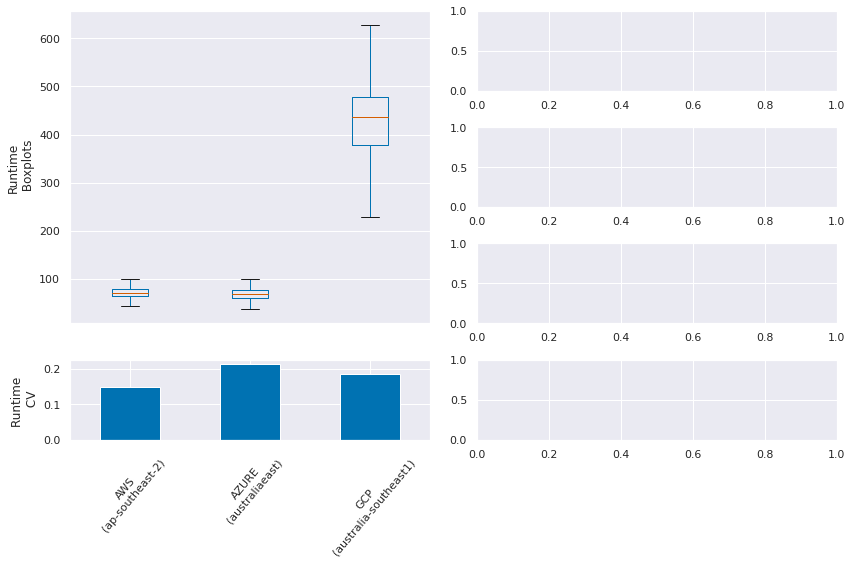

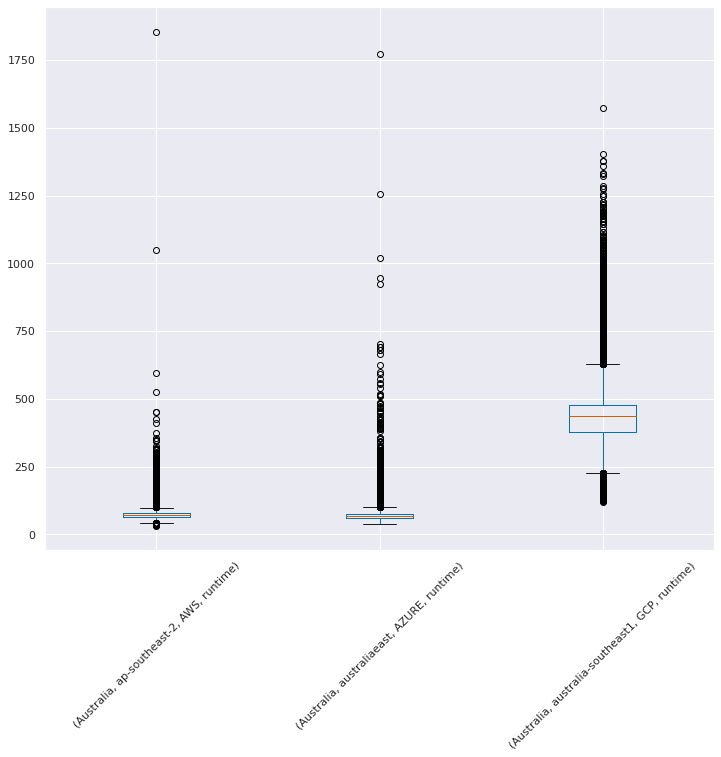

Canada


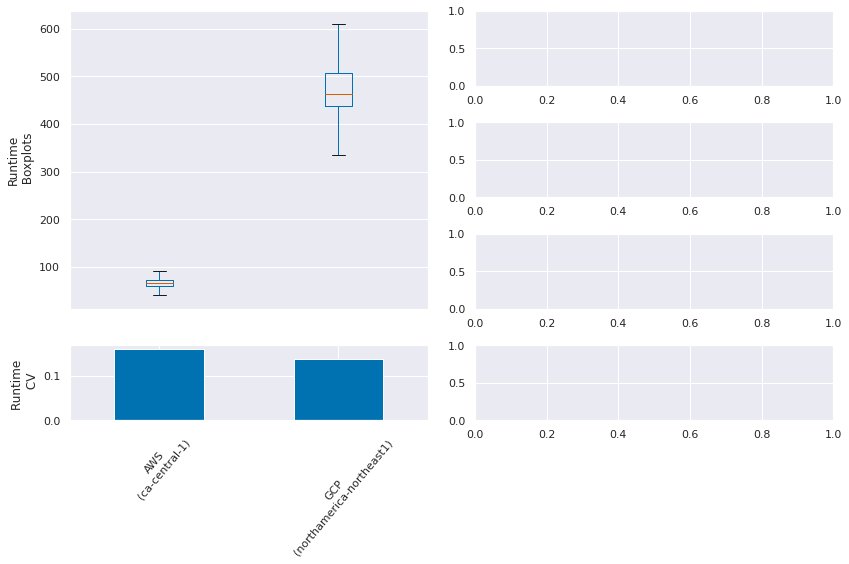

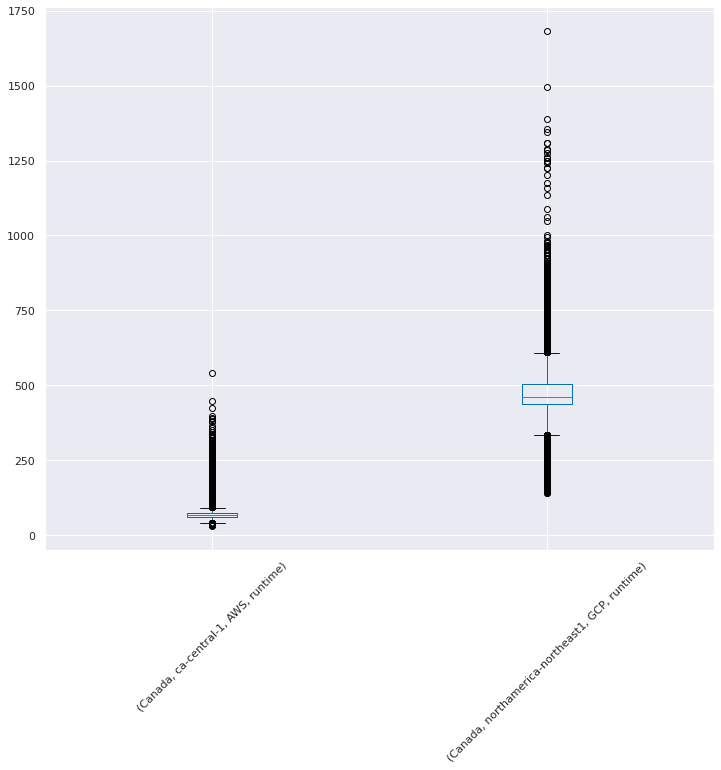

East US


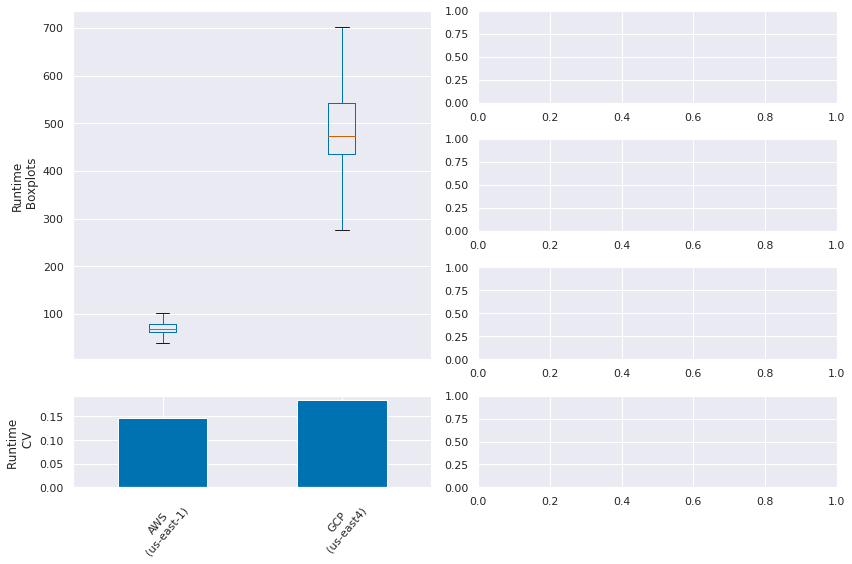

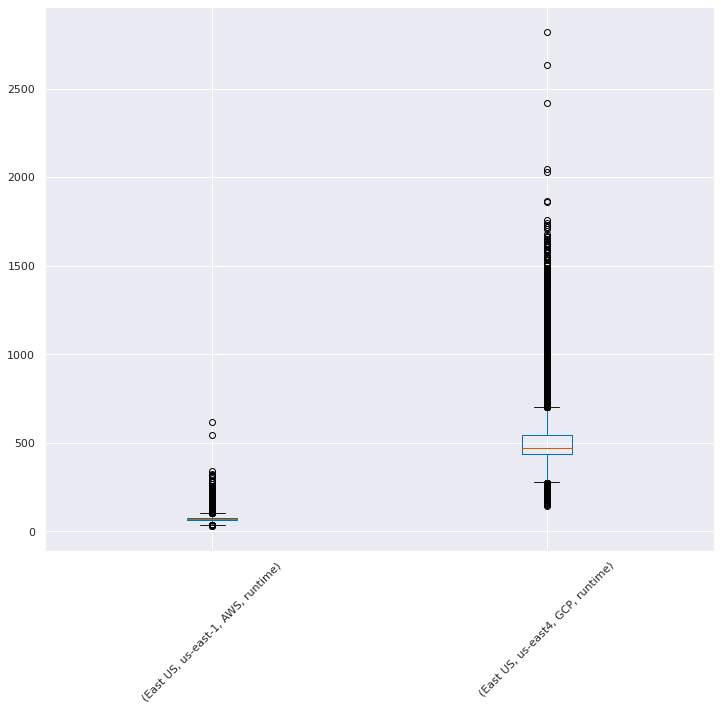

Germany


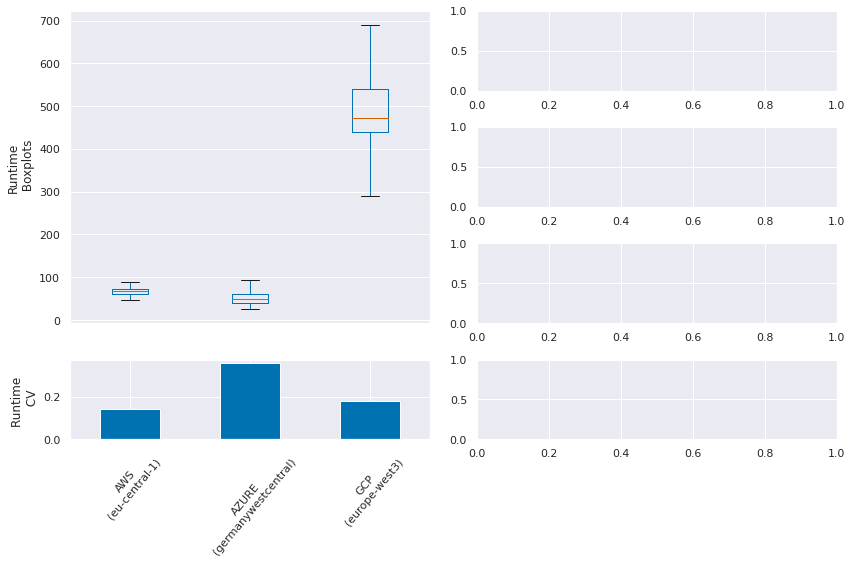

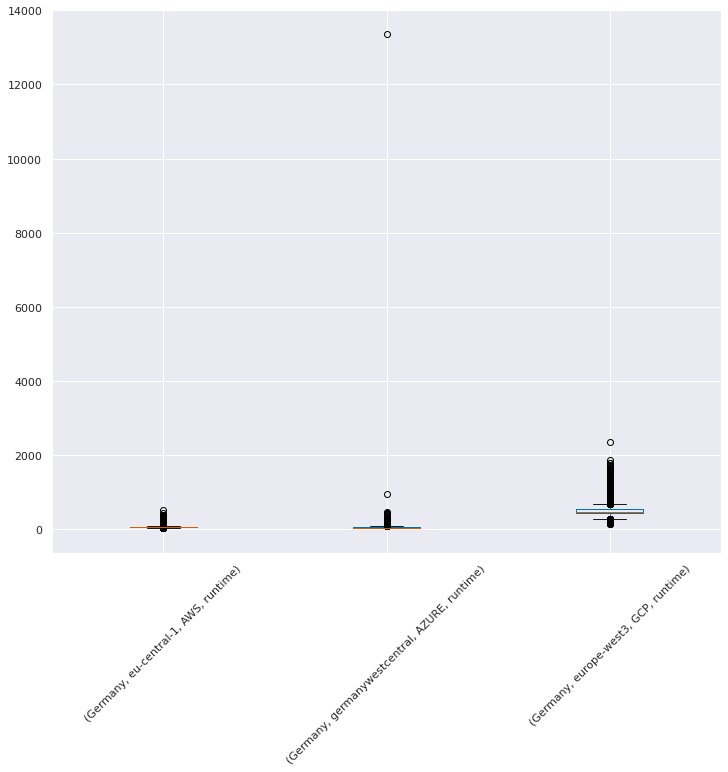

India


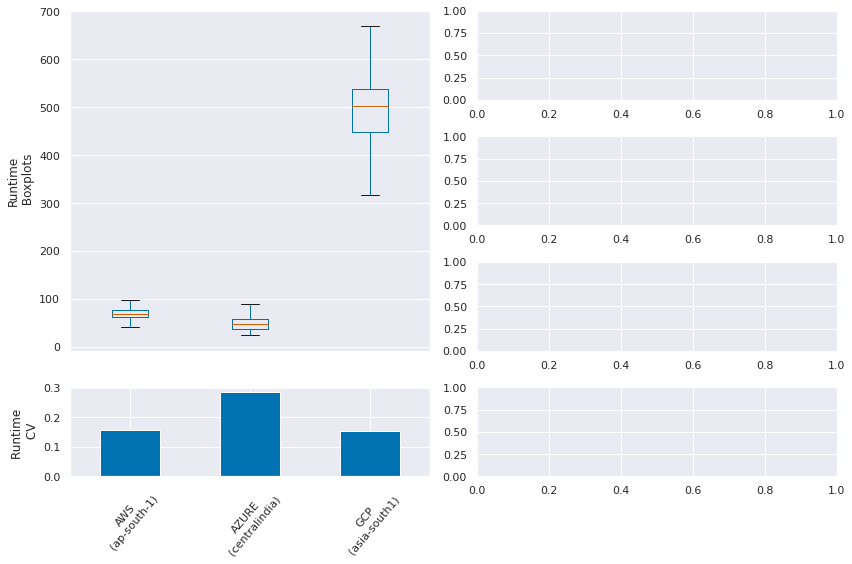

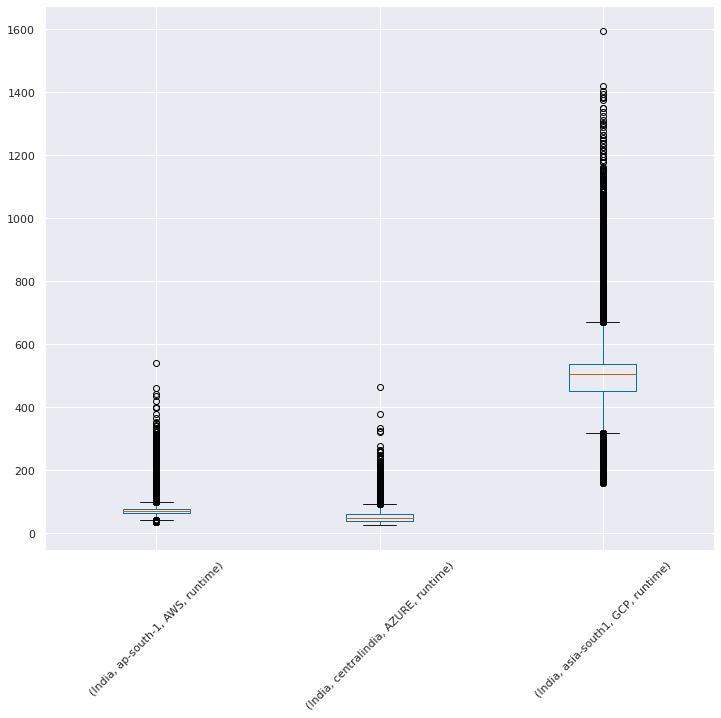

Japan


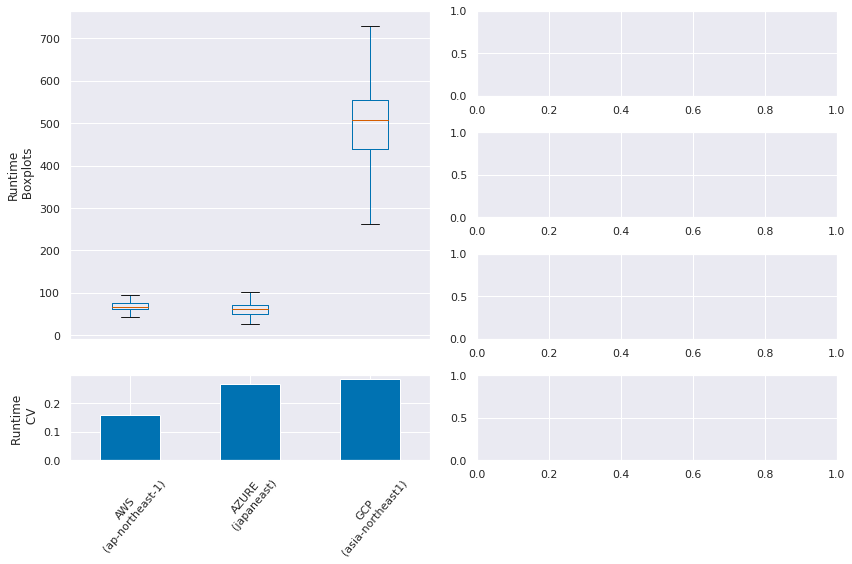

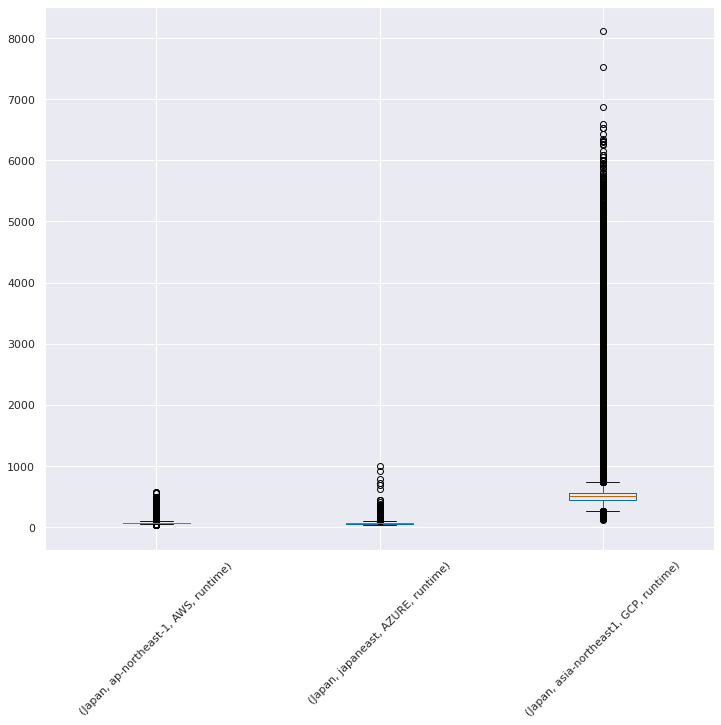

South America


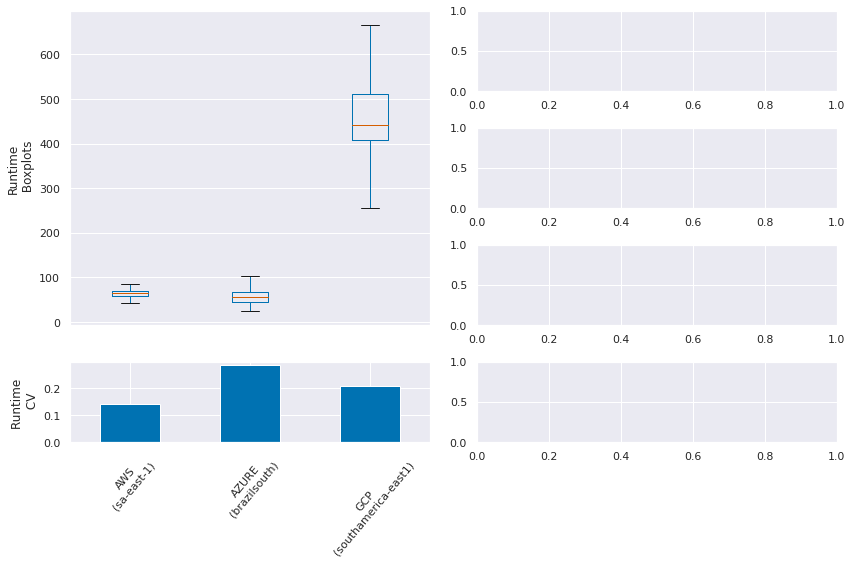

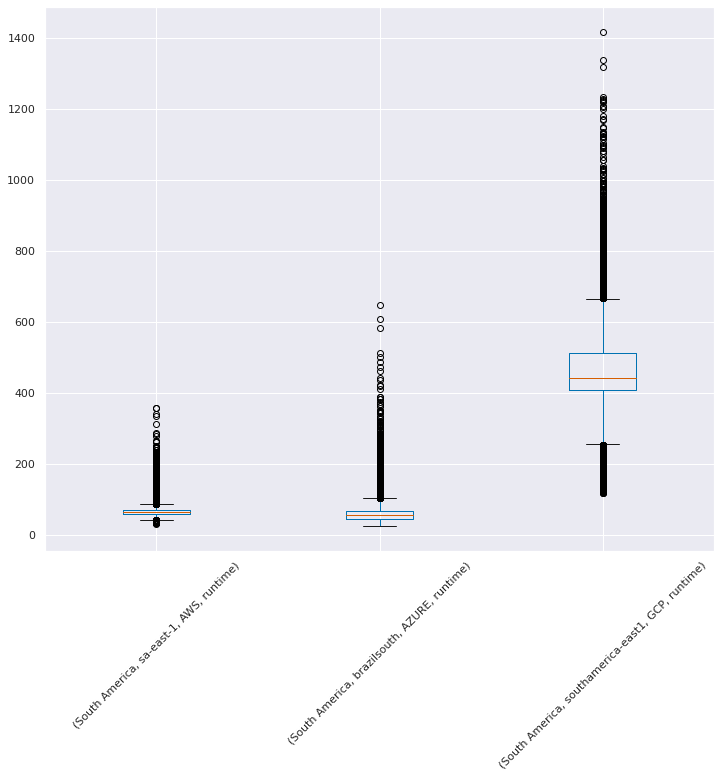

United Kingdom


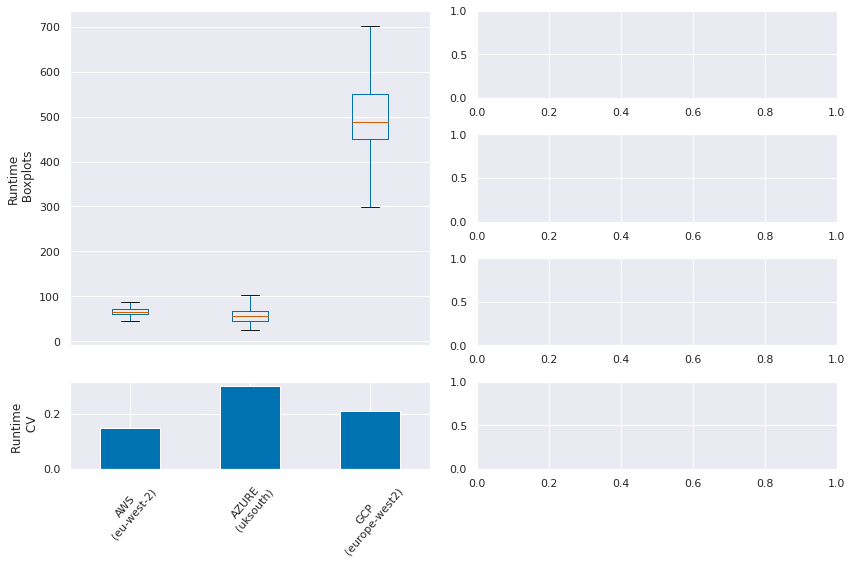

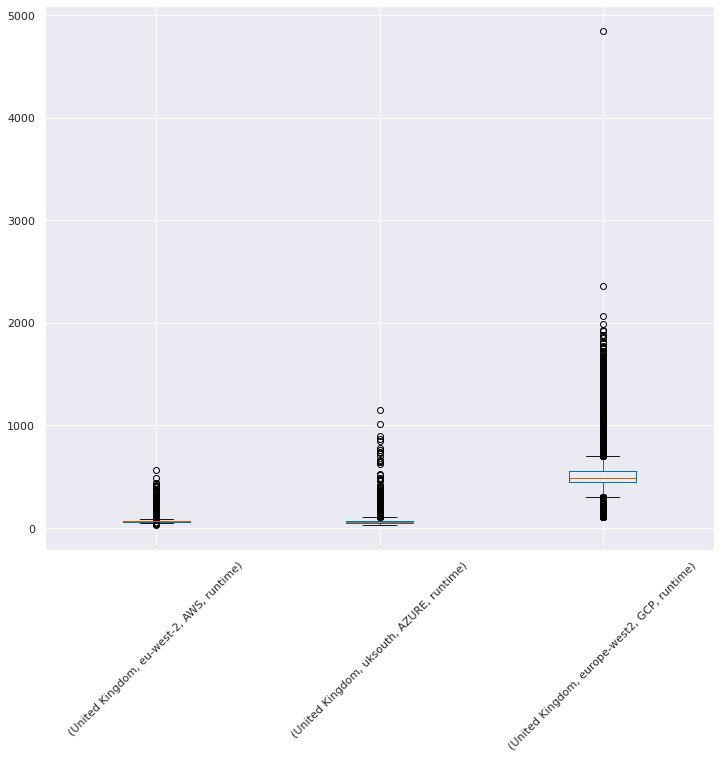

West US


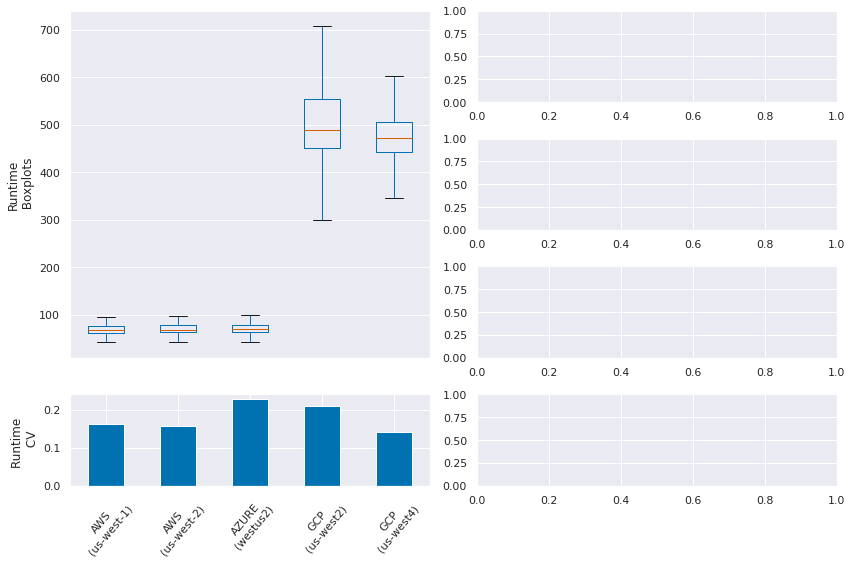

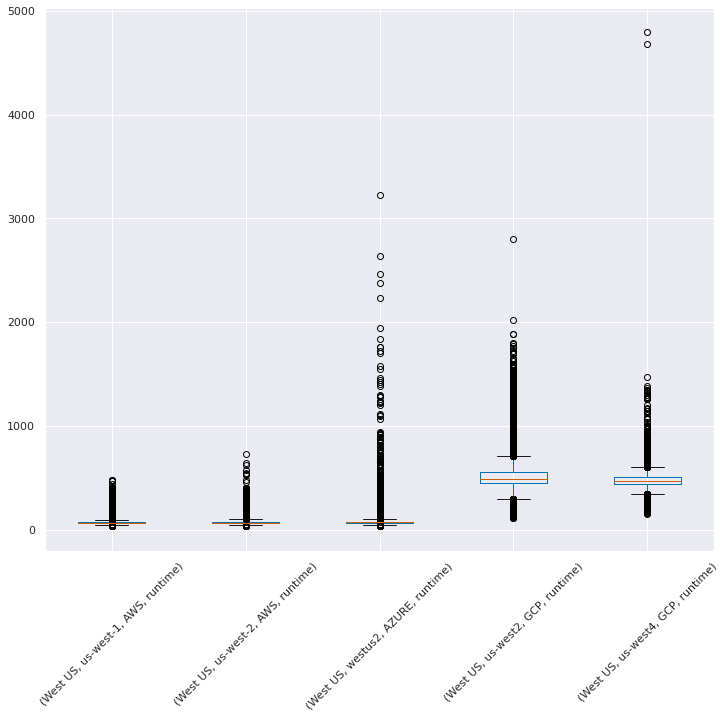

In [40]:
dataset = dataset.sort_values(by=['measure_group', 'provider', 'region'])

for measure_group in cov_regional_df.index.get_level_values('measure_group').unique():
  fig, axes = plt.subplots(figsize=(12,8), nrows=4, ncols=2, frameon=False)

  gs = axes[0, 0].get_gridspec()
  axes[0, 0].remove()
  axes[1, 0].remove()
  axes[2, 0].remove()
  axbig = fig.add_subplot(gs[:3, 0])

  cov_regional_df[cov_regional_df.index.isin([measure_group], level='measure_group')].plot(kind='bar', ax=axes[3, 0])
  dataset[['measure_group', 'provider', 'region', 'runtime']][dataset['measure_group'] == measure_group].groupby(['measure_group', 'region', 'provider'], observed=True).boxplot(subplots=False, ax=axbig, showfliers=False)

  axbig.get_xaxis().set_ticks([])

  axbig.set_ylabel('Runtime\n Boxplots')

  # Set Region Names
  labels = []
  for tick in axes[3, 0].get_xticklabels():
    mapping = provider_region_mapping[tick.get_text()]
    labels.append(f"{mapping['provider']}\n({mapping['region']})")

  axes[3, 0].get_legend().remove()
  axes[3, 0].set_ylabel('Runtime \n CV')
  axes[3, 0].set_xticklabels(labels)
  axes[3, 0].set_xlabel('')
  for tick in axes[3, 0].get_xticklabels():
    tick.set_rotation(50)

  fig.tight_layout()

  print(measure_group)
  plt.savefig(f'cov_regional_cov_boxplot_{measure_group}.pdf')
  plt.show()
  plt.close()

  # # Generate a control figure - to check if correct
  fig, axes = plt.subplots(figsize=(12,10))
  dataset[['measure_group', 'provider', 'region', 'runtime']][dataset['measure_group'] == measure_group].groupby(['measure_group', 'region', 'provider'], observed=True).boxplot(subplots=False, ax=axes, rot=45)
  plt.savefig(f'cov_regional_cov_boxplot_{measure_group}_control.pdf')
  plt.show()
  plt.close()

# Other Stuff (Experimental)

In [41]:
dataset

driver_invocation     workload_invocation  dirty_measurement  \
3689999  2021-08-02 00:00:04.969 2021-08-02 00:00:55.132               True   
3690000  2021-08-06 18:00:05.096 2021-08-06 18:00:54.131               True   
3690001  2021-08-02 00:00:04.969 2021-08-02 00:00:55.132               True   
3690002  2021-08-06 18:00:05.096 2021-08-06 18:00:54.131               True   
3690003  2021-08-02 00:00:04.969 2021-08-02 00:00:55.132               True   
...                          ...                     ...                ...   
49476535 2021-10-04 04:00:03.936 2021-10-04 04:00:22.978               True   
49476536 2021-10-04 04:00:03.936 2021-10-04 04:00:22.978               True   
49476537 2021-10-04 04:00:03.936 2021-10-04 04:00:22.978               True   
49476538 2021-10-04 04:00:03.936 2021-10-04 04:00:22.978               True   
49476539 2021-10-04 04:00:03.936 2021-10-04 04:00:22.978               True   

                                   folder_uuid 1_run_id  2_thread_id  \
3689999   69f65f4e-28e0-11ec-9462-00155d9a91fa        0          0.0   
3690000   cef22086-28e0-11ec-bafa-00155d9a91fa        0          0.0   
3690001   69f65f4e-28e0-11ec-9462-00155d9a91fa        0          1.0   
3690002   cef22086-28e0-11ec-bafa-00155d9a91fa        0          1.0   
3690003   69f65f4e-28e0-11ec-9462-00155d9a91fa        0          2.0   
...                                        ...      ...          ...   
49476535  84d57dbc-28e6-11ec-94e2-00155d9a91fa       98          3.0   
49476536  84d57dbc-28e6-11ec-94e2-00155d9a91fa       99          0.0   
49476537  84d57dbc-28e6-11ec-94e2-00155d9a91fa       99          1.0   
49476538  84d57dbc-28e6-11ec-94e2-00155d9a91fa       99          2.0   
49476539  84d57dbc-28e6-11ec-94e2-00155d9a91fa       99          3.0   

                  SAAFMemoryDeltaError               SAAFMemoryError  \
3689999                           None                          None   
3690000                           None                          None   
3690001                           None                          None   
3690002                           None                          None   
3690003                           None                          None   
...                                ...                           ...   
49476535  /proc/vmstat does not exist!  /proc/vmstat does not exist!   
49476536  /proc/vmstat does not exist!  /proc/vmstat does not exist!   
49476537  /proc/vmstat does not exist!  /proc/vmstat does not exist!   
49476538  /proc/vmstat does not exist!  /proc/vmstat does not exist!   
49476539  /proc/vmstat does not exist!  /proc/vmstat does not exist!   

          contextSwitches  contextSwitchesDelta  ...  functionMemory    vmID  \
3689999           18113.0                  46.0  ...          1024.0  ceHwbi   
3690000           18426.0                  46.0  ...          1024.0  Uh1dIx   
3690001           20168.0                  41.0  ...          1024.0  HhcEzS   
3690002           24982.0                  49.0  ...          1024.0  LVhiDn   
3690003           19989.0                  47.0  ...          1024.0  YUYwl1   
...                   ...                   ...  ...             ...     ...   
49476535              0.0                   0.0  ...             NaN    None   
49476536              0.0                   0.0  ...             NaN    None   
49476537              0.0                   0.0  ...             NaN    None   
49476538              0.0                   0.0  ...             NaN    None   
49476539              0.0                   0.0  ...             NaN    None   

          __index_level_0__  tod_utc  measure_group             timezone  \
3689999                   0     0000      Australia     Australia/Sydney   
3690000                   2     1800      Australia     Australia/Sydney   
3690001                   1     0000      Australia     Australia/Sydney   
3690002                   0     1800      Australia     Australia/Sydne

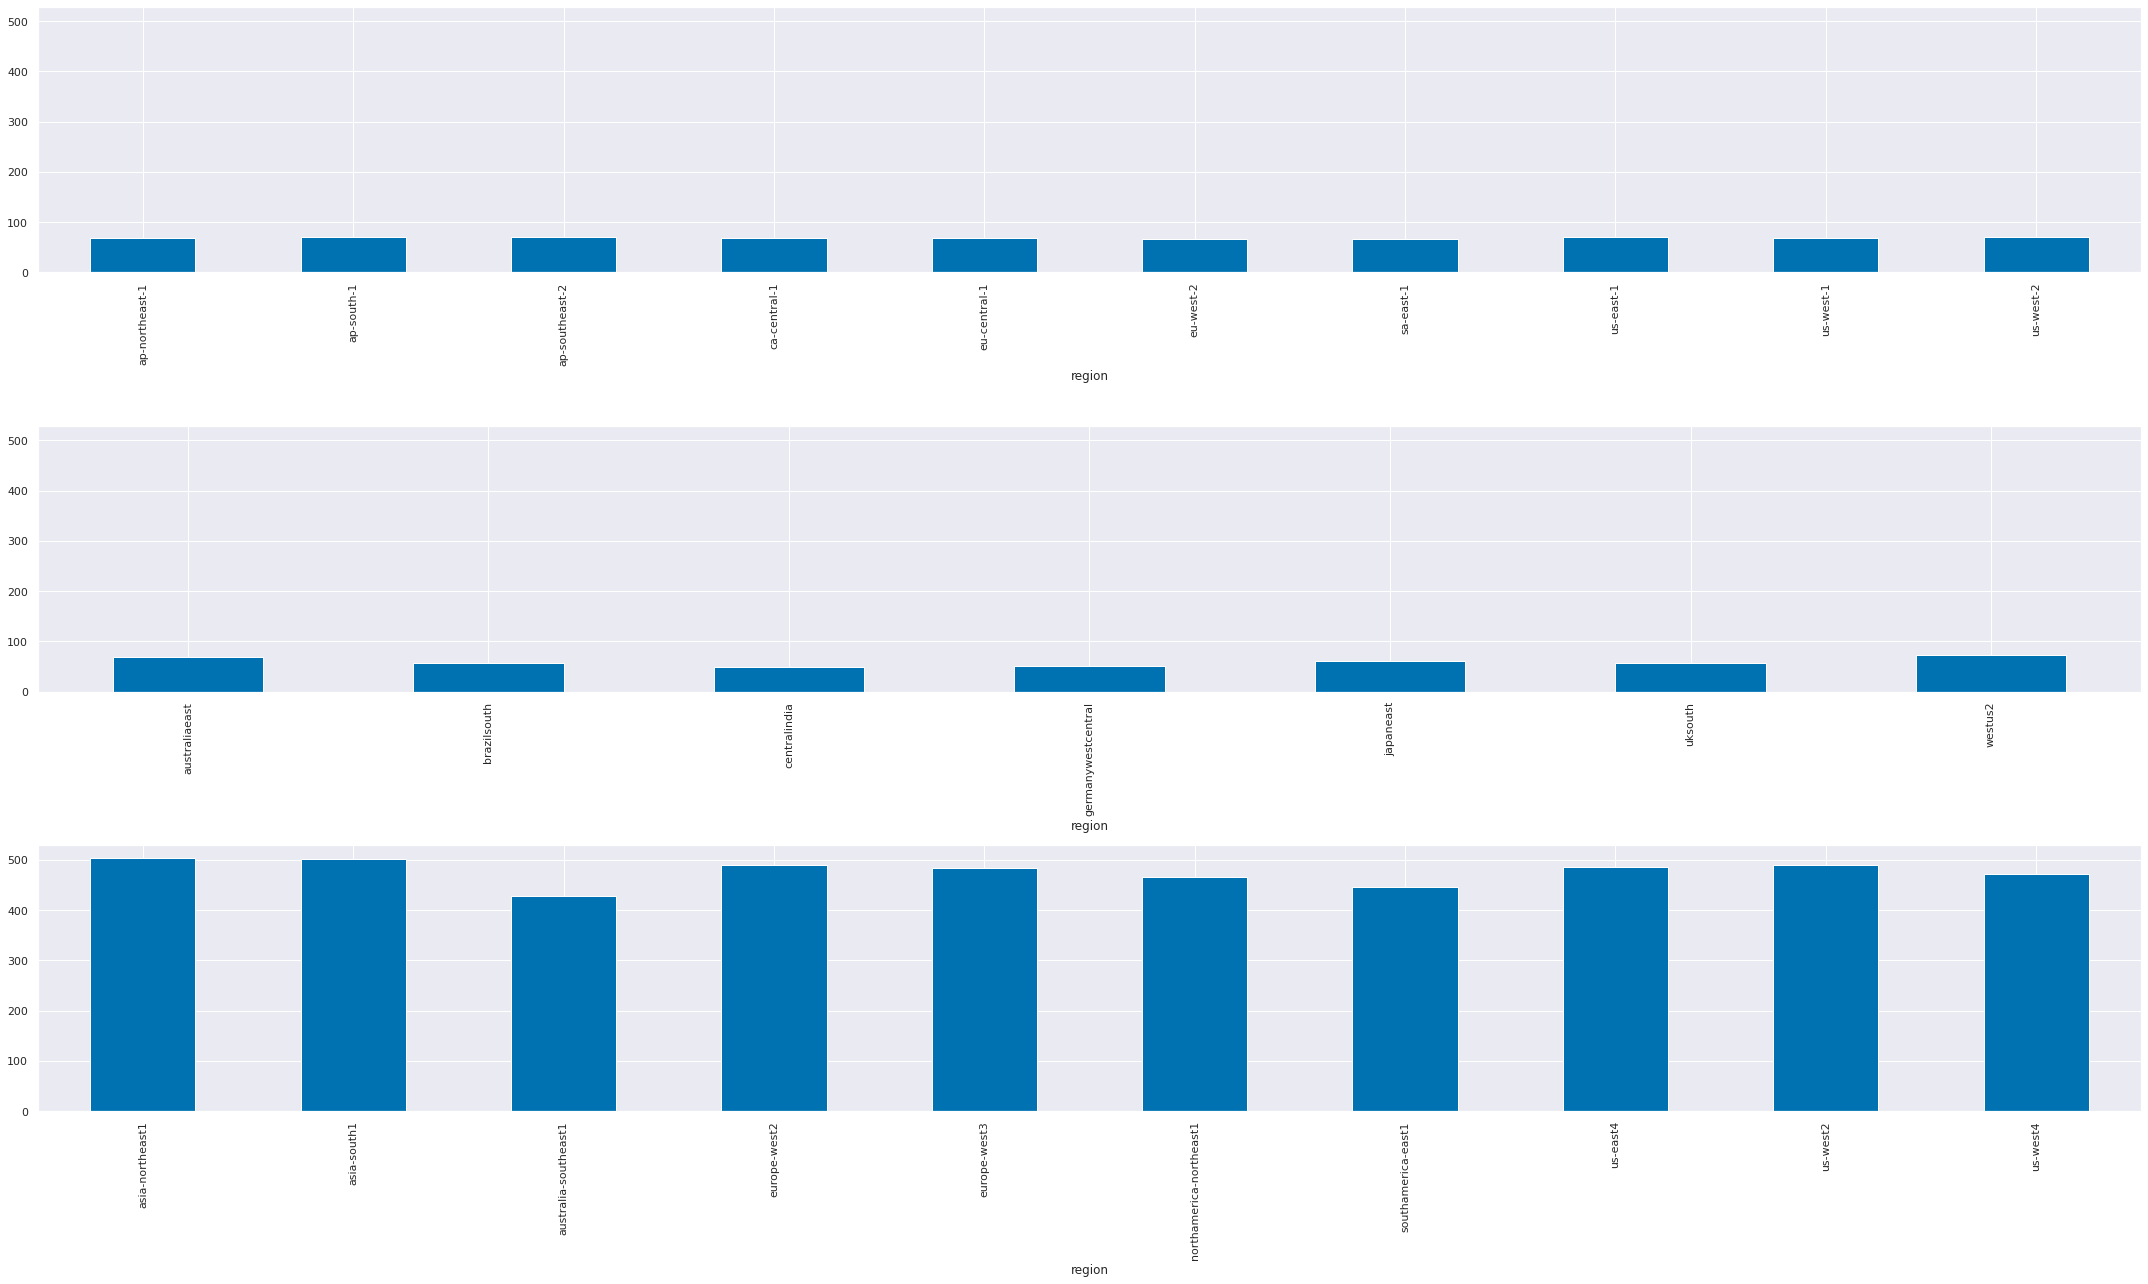

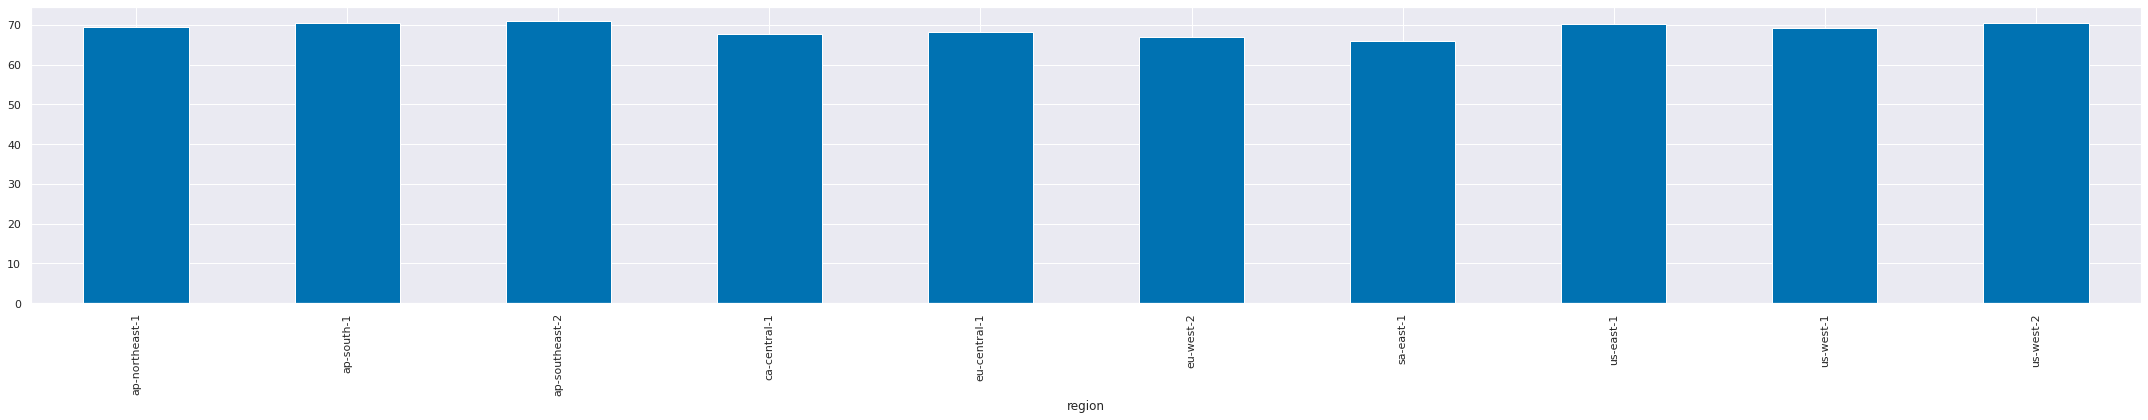

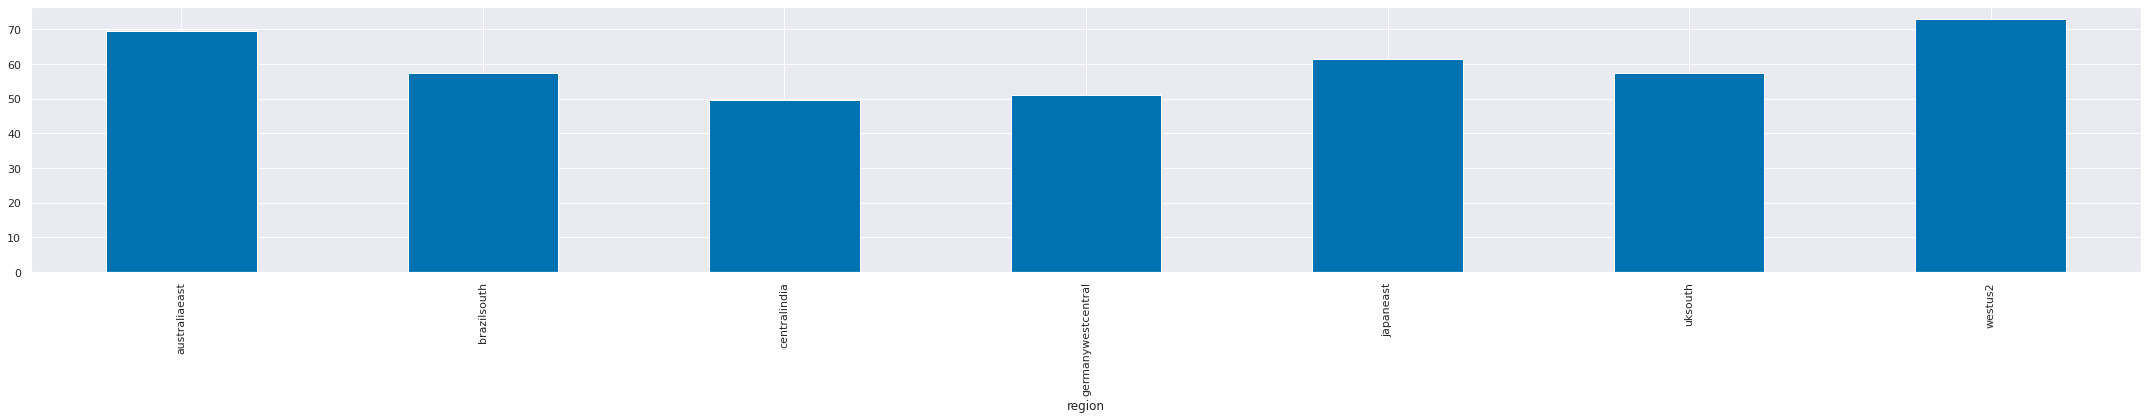

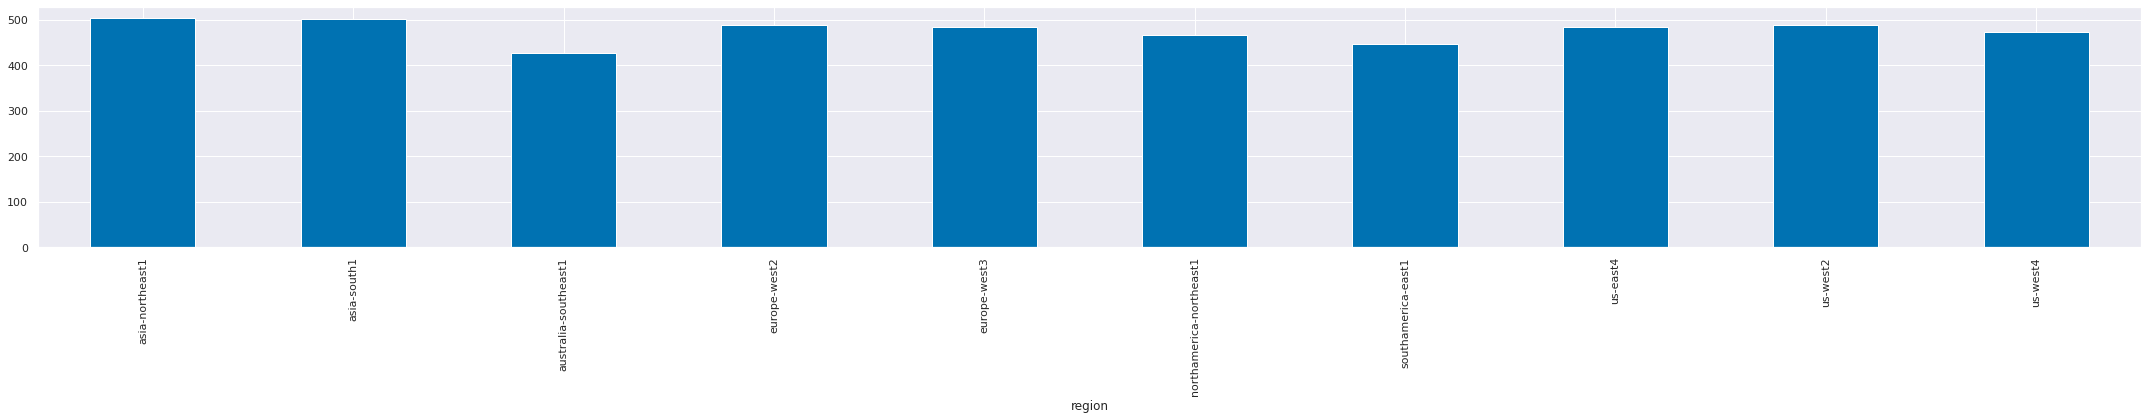

In [42]:
fig, axes = plt.subplots(figsize=(30,18), nrows=3, ncols=1, sharey='all')
dataset[dataset['provider'] == 'AWS'].sort_values(['measure_group']).groupby( ['region'])['runtime'].mean().dropna().plot(kind='bar', by='region', ax=axes[0])
dataset[dataset['provider'] == 'AZURE'].sort_values(['measure_group']).groupby( ['region'])['runtime'].mean().dropna().plot(kind='bar', by='region', ax=axes[1])
dataset[dataset['provider'] == 'GCP'].sort_values(['measure_group']).groupby( ['region'])['runtime'].mean().dropna().plot(kind='bar', by='region', ax=axes[2])

fig.tight_layout()
plt.show()
plt.close()

fig, axes = plt.subplots(figsize=(30,6))
dataset[dataset['provider'] == 'AWS'].sort_values(['measure_group']).groupby( ['region'])['runtime'].mean().dropna().plot(kind='bar', by='region', ax=axes)
fig.tight_layout()
plt.show()
plt.close()

fig, axes = plt.subplots(figsize=(30,6))
dataset[dataset['provider'] == 'AZURE'].sort_values(['measure_group']).groupby( ['region'])['runtime'].mean().dropna().plot(kind='bar', by='region', ax=axes)
fig.tight_layout()
plt.show()
plt.close()

fig, axes = plt.subplots(figsize=(30,6))
dataset[dataset['provider'] == 'GCP'].sort_values(['measure_group']).groupby( ['region'])['runtime'].mean().dropna().plot(kind='bar', by='region', ax=axes)
fig.tight_layout()
plt.show()
plt.close()

In [4]:
provider_regions_df = dataset[['provider', 'region']].value_counts().reset_index(name='count')

In [6]:
def plot_mean_col(dataset, provider, region, col):
    provider_df = dataset[dataset['provider'] == provider]
    provider_region_df = provider_df[provider_df['region'] == region]
    mean_latency_df = provider_region_df.groupby(['driver_invocation'])[col].mean()
    
    fig, ax = plt.subplots(figsize=(220,6))
    mean_latency_df.plot(title=f'{provider} {region} mean {col}', style='.-')

    hours = mdates.MinuteLocator(byminute=[0,30]) #or use interval

    hours.MAXTICKS = 3392

    h_fmt = mdates.DateFormatter('%a %H')


    ax.xaxis.set_major_locator(hours)
    ax.xaxis.set_major_formatter(h_fmt)

    fig.autofmt_xdate()

    plt.xticks(rotation=90)
    plt.savefig(f'plot_mean_col_long_{provider}_{region}_{col}.pdf')
    plt.show()
    plt.close()

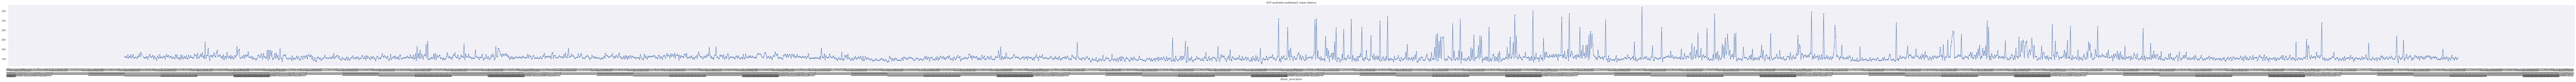

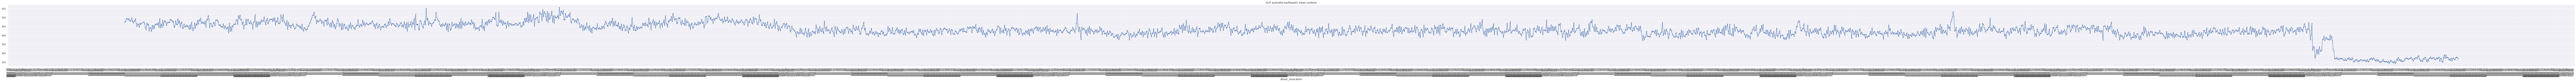

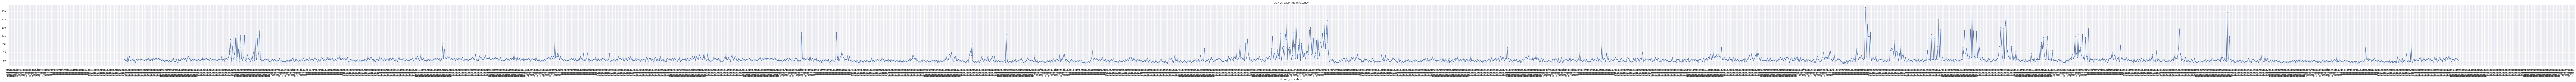

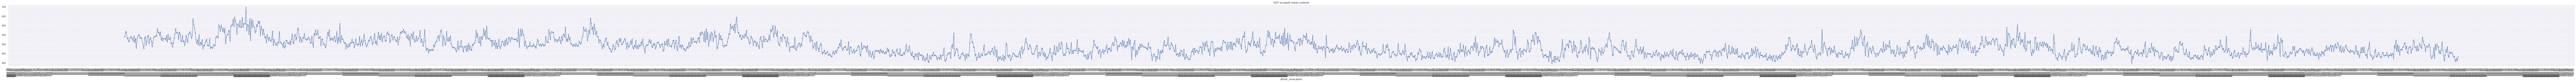

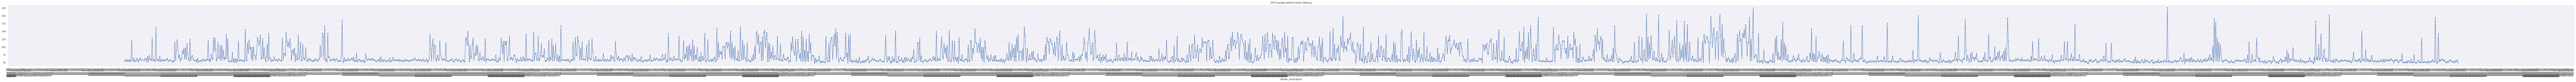

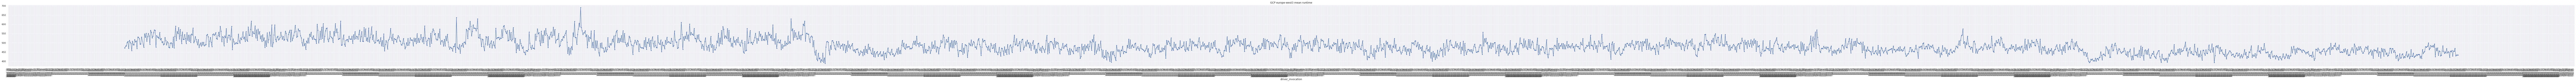

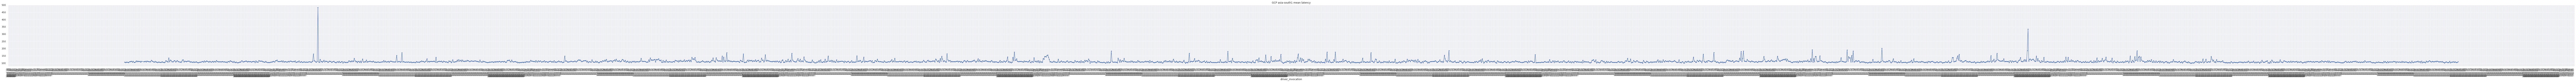

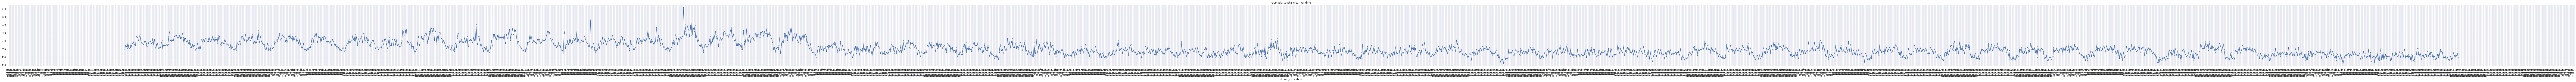

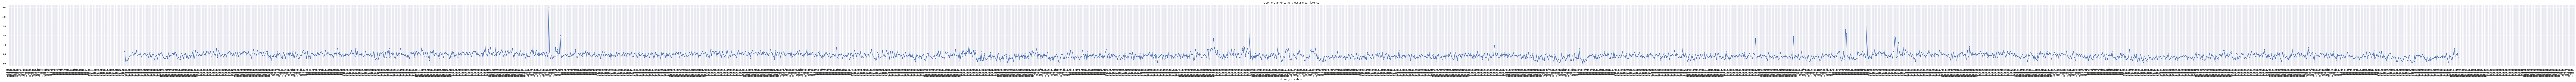

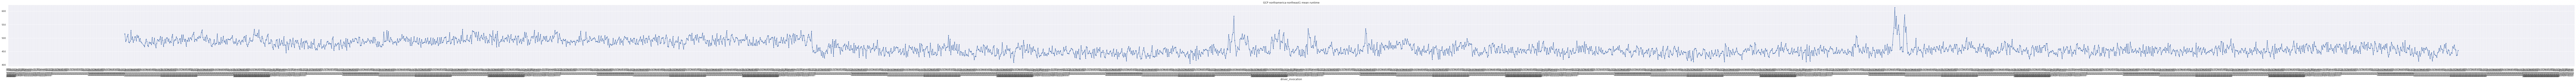

In [ ]:
for index, row in provider_regions_df.iterrows():
    provider = row['provider']
    region =  row['region']
    plot_mean_col(dataset, provider, region, 'latency')
    plot_mean_col(dataset, provider, region, 'runtime')


In [ ]:
unique_cpu_models = dataset.groupby(['provider'])['cpuModel'].nunique()
unique_vendors = dataset.groupby(['provider'])['vendorId'].nunique()

In [ ]:
fig, ax = plt.subplots(figsize=(240,8))
dataset.groupby(['driver_invocation', 'provider'])['cpuType'].nunique().unstack().plot(ax=ax, kind='line')

plt.xticks(rotation=90)
plt.show()
plt.close()

In [ ]:
region = 'sa-east-1'
provider = 'AWS'

In [ ]:
for mg in measure_groups:
  for provider in measure_groups[mg]['providers']:
    regions = measure_groups[mg]['providers'][provider]
    if len(regions) > 0:
      
      for region in regions:
        fig, ax = plt.subplots(figsize=(12,8))
        df = dataset[ (dataset['region'] == region) & (dataset['provider'] == provider)]
        df.groupby(['local_dow'])['runtime'].agg(['mean', 'std']).loc[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']].plot(title=f'{mg} - {provider} Mean with Std, {region}', kind='bar', yerr='std', ax=ax)

        plt.show()
        plt.close()

In [ ]:
mgs = measure_groups.keys()
for mg in mgs:
  for provider in measure_groups[mg]['providers']:
    regions = measure_groups[mg]['providers'][provider]
    if len(regions) > 0:
      
      for region in regions:
        fig, ax = plt.subplots(figsize=(24,8))
        df = dataset[ (dataset['region'] == region) & (dataset['provider'] == provider)]
        df.groupby(['local_tod'])['runtime'].agg(['mean', 'std']).plot(title=f'{mg} - {provider} Mean with Std, {region}', kind='bar', yerr='std', ax=ax)
        plt.show()
        plt.close()

In [ ]:
def get_average_responses_per_region_and_local_tod(dataset):
  df = dataset.groupby(['region', 'local_tod'])[ ['driver_invocation'] ].agg(['count', 'nunique'])
  return (df[ ('driver_invocation', 'count') ] / df[ ('driver_invocation', 'nunique') ]).reset_index(name ='Average Responses')
avg_reponses_df = get_average_responses_per_region_and_local_tod(dataset)
avg_reponses_df = avg_reponses_df.set_index('local_tod')

In [ ]:
measure_group_region_df = dataset.groupby('measure_group')['region'].unique()
for mg in measure_group_region_df.index:
    regions = measure_group_region_df.loc[mg]
    for region in regions:
        fig, ax = plt.subplots(figsize=(24,8))
        df = avg_reponses_df[avg_reponses_df['region'] == region]
        df.plot(title=f'{mg} Mean with Std, {region}', kind='bar',  ax=ax)
        plt.show()
        plt.close()

In [ ]:
def decompose(dataset, provider, region):
  df = dataset[ (dataset['provider'] == provider) & (dataset['region'] == region) ].groupby(['driver_invocation'])[['runtime']].mean()
  with plt.rc_context():
      plt.rc("figure", figsize=(20,8))
      result = seasonal_decompose(df, model='additive', freq=48)
      
      fig, axis = plt.subplots(figsize=(24,12), sharex=True, nrows=4)

      axis[0].plot(result.observed)
      plt.setp(axis[0], ylabel='Observed')

      axis[1].plot(result.resid)
      plt.setp(axis[1], ylabel='Residuals')

      axis[2].plot(result.trend)
      plt.setp(axis[2], ylabel='Trend')

      axis[3].plot(result.seasonal)
      plt.setp(axis[3], ylabel='Seasonal')

      hours = mdates.HourLocator(interval=12) #or use interval
      hours.MAXTICKS = 1500

      h_fmt = mdates.DateFormatter('%a %H')

      axis[0].xaxis.set_major_locator(hours)
      axis[0].xaxis.set_major_formatter(h_fmt)

      axis[1].xaxis.set_major_locator(hours)
      axis[1].xaxis.set_major_formatter(h_fmt)

      axis[2].xaxis.set_major_locator(hours)
      axis[2].xaxis.set_major_formatter(h_fmt)

      axis[3].xaxis.set_major_locator(hours)
      axis[3].xaxis.set_major_formatter(h_fmt)

      fig.autofmt_xdate()

      fig.suptitle(f"Decomposition for {provider} - {region}")

      plt.show()
      plt.close()

      return result

In [ ]:
result = decompose(dataset, 'AZURE', 'japaneast')

In [ ]:
decompose(dataset, 'AZURE', 'japaneast')
decompose(dataset, 'GCP', 'asia-northeast1')
decompose(dataset, 'AWS', 'ap-northeast-1')

In [ ]:
decompose(dataset, 'AWS', 'us-west-1')
decompose(dataset, 'AWS', 'us-west-2')

In [ ]:
decompose(dataset, 'GCP', 'us-west2')
decompose(dataset, 'GCP', 'us-west4')